# data ~20240218

In [1]:
import sklearn
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import r2_score
import numpy as np

In [2]:
import statsmodels.api as sma
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sma.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sma.add_constant(X)
        return self.results_.predict(X)

In [3]:
def create_dose_per_period_lst(freq,range_end):
    lst_dose_per=[]
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_dose_per.append('all_dose_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_dose_per.append('all_dose_{}m+'.format(st_lab))
    
    return lst_dose_per

In [4]:
def create_Ndose_period_lst(freq,range_end):
    lst_1dose=[]
    lst_2dose=[]
    lst_3dose=[]
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_1dose.append('1dose_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_1dose.append('1dose_{}m+'.format(st_lab))
    
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_2dose.append('2dose_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_2dose.append('2dose_{}m+'.format(st_lab))
    
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_3dose.append('3dose_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_3dose.append('3dose_{}m+'.format(st_lab))
    return lst_1dose,lst_2dose,lst_3dose

In [5]:
def create_overall_period_lst(freq,range_end):
    lst_overall=[]
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_overall.append('overall_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_overall.append('overall_{}m+'.format(st_lab))
    return lst_overall #_1dose,lst_2dose,lst_3dose

In [6]:
from scipy.ndimage import shift
def feature_extraction_vax_per_st(df,Country_lst,use_lst,start_date,end_date,vax_data_freq,st_per):
    #['max_1st_rate','max_2nd_rate','max_3rd_rate']
    new_df = pd.DataFrame(columns=use_lst)
    for Countryname in Country_lst : 
        tmp_df=df[df['location']==Countryname].reset_index(drop=True)
                
        tmp_df[lst_dose_per] = 0 # lst_1dose+lst_2dose+lst_3dose]=0
        tmp_df['total_vaccinations_per_hundred'] = tmp_df['total_vaccinations_per_hundred'].fillna(method='ffill').fillna(int(0))
        tmp_df['total_vaccinations_per_hundred_diff'] = tmp_df['total_vaccinations_per_hundred'].diff().shift(-1)/100
        
        st_dose = tmp_df[tmp_df['total_vaccinations_per_hundred']>st_per]['date'].iloc[0]
        print(Countryname,st_dose) #,st_2dose,st_3dose)
        
        ############### vax_per_period #############
        dict_dose={}
        tmp_lst=[]
        date_lst = tmp_df[(tmp_df['date']>=st_dose) & (tmp_df['total_vaccinations_per_hundred_diff'].notna())]['date'].values #.reset_index(drop=True)
        for d in date_lst:
            st = datetime.strptime(d,'%Y-%m-%d')
            tmp_vax_per_diff = tmp_df[tmp_df['date']==d]['total_vaccinations_per_hundred_diff'].values[0]
            tmp_lst.append(tmp_vax_per_diff)
            for i in range(len(lst_dose_per))[:-1]:
                et = st + relativedelta(months=+vax_data_freq) # + relativedelta(days=+1)
                dict_dose[lst_dose_per[i]] = (str(st)[:10],str(et)[:10])
                #print(st,et)
                tmp_df.loc[(tmp_df['date']>datetime.strftime(st,'%Y-%m-%d')) & (tmp_df['date']<=datetime.strftime(et,'%Y-%m-%d')),lst_dose_per[i]] = tmp_df[(tmp_df['date']>datetime.strftime(st,'%Y-%m-%d')) & (tmp_df['date']<=datetime.strftime(et,'%Y-%m-%d'))][lst_dose_per[i]] + tmp_vax_per_diff
                st = et + relativedelta(days=+1)
            et = st + relativedelta(months=+24)
            #print(st,et)
            tmp_df.loc[(tmp_df['date']>datetime.strftime(st,'%Y-%m-%d')) & (tmp_df['date']<=datetime.strftime(et,'%Y-%m-%d')),lst_dose_per[i+1]] = tmp_df[(tmp_df['date']>datetime.strftime(st,'%Y-%m-%d')) & (tmp_df['date']<=datetime.strftime(et,'%Y-%m-%d'))][lst_dose_per[i+1]] + tmp_vax_per_diff

        plt_df = pd.DataFrame(columns=use_lst)
        ####################################################
        plt_df = pd.concat([plt_df,tmp_df])[use_lst]
        #print(plt_df['total_vaccinations_per_hundred_diff'].sum())
        plt_df = plt_df.fillna(method='bfill').dropna(subset=['new_deaths','new_deaths_smoothed','excess_mortality']).fillna(int(0))
        #print(tmp_df['total_vaccinations_per_hundred_diff'].sum())
        #print(plt_df['total_vaccinations_per_hundred_diff'].sum())
        #tmp_last_year_cov = plt_df['new_deaths_smoothed'].rolling(window=30,min_periods=1).mean() #,center=True
        #plt_df['last_year_new_deaths_smoothed_1_3m'] = shift(tmp_last_year_cov, 0, cval=np.NaN) #60
        #plt_df['last_year_new_deaths_smoothed_4_6m'] = shift(tmp_last_year_cov, 30, cval=np.NaN) #60
        #plt_df['last_year_new_deaths_smoothed_7_9m'] = shift(tmp_last_year_cov, 60, cval=np.NaN) #60
        #plt_df['last_year_new_deaths_smoothed_10_12m'] = shift(tmp_last_year_cov, 90, cval=np.NaN) #60
        #plt_df['last_year_new_deaths_smoothed_13_15m'] = shift(tmp_last_year_cov, 120, cval=np.NaN) #60
        tmp_last_year_cov = plt_df['new_deaths_smoothed'].rolling(window=90,min_periods=1).mean() #,center=True
        
        plt_df['last_year_new_deaths_smoothed_1_3m'] = shift(tmp_last_year_cov, 0, cval=np.NaN) #60
        plt_df['last_year_new_deaths_smoothed_4_6m'] = shift(tmp_last_year_cov, 90, cval=np.NaN) #60
        plt_df['last_year_new_deaths_smoothed_7_9m'] = shift(tmp_last_year_cov, 180, cval=np.NaN) #60
        plt_df['last_year_new_deaths_smoothed_10_12m'] = shift(tmp_last_year_cov, 270, cval=np.NaN) #60
        plt_df['last_year_new_deaths_smoothed_13_15m'] = shift(tmp_last_year_cov, 365, cval=np.NaN) #60

        #tmp_last_year_cov = plt_df['new_deaths_smoothed'].rolling(window=180,min_periods=1).mean() #,center=True
        #plt_df['last_year_new_deaths_smoothed_1m'] = shift(tmp_last_year_cov, 0, cval=np.NaN) #60
        
        plt_df = plt_df[plt_df['date']>=start_date].reset_index(drop=True)
        plt_df = plt_df[plt_df['date']<=end_date].reset_index(drop=True)
        if plt_df['excess_mortality'].unique().shape[0]<=5:
            print('****skipping {} data for lack of excess_mortality.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].unique().shape[0]<=10:
            print('****skipping {} data for lack of new_deaths_smoothed.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].max() == 0:
            continue
        
        #plt_df['excess_mortality_Norm'] = plt_df['excess_mortality']/plt_df['excess_mortality'].max()
        plt_df['new_deaths_smoothed_Norm'] = plt_df['new_deaths_smoothed']/plt_df['new_deaths_smoothed'].max()
        plt_df['last_year_new_deaths_smoothed_1_3m_Norm'] = plt_df['last_year_new_deaths_smoothed_1_3m']/plt_df['new_deaths_smoothed'].max()
        plt_df['last_year_new_deaths_smoothed_4_6m_Norm'] = plt_df['last_year_new_deaths_smoothed_4_6m']/plt_df['new_deaths_smoothed'].max()
        plt_df['last_year_new_deaths_smoothed_7_9m_Norm'] = plt_df['last_year_new_deaths_smoothed_7_9m']/plt_df['new_deaths_smoothed'].max()
        plt_df['last_year_new_deaths_smoothed_10_12m_Norm'] = plt_df['last_year_new_deaths_smoothed_10_12m']/plt_df['new_deaths_smoothed'].max()
        plt_df['last_year_new_deaths_smoothed_13_15m_Norm'] = plt_df['last_year_new_deaths_smoothed_13_15m']/plt_df['new_deaths_smoothed'].max()


        #plt_df['last_year_new_deaths_smoothed_1m_Norm'] = plt_df['last_year_new_deaths_smoothed_1m']/plt_df['new_deaths_smoothed'].max()

        # re-estimate excess mortality
        plt_df['re_est_ex_mortality'] = (plt_df['excess_mortality']+100)/(plt_df['excess_mortality'].min()+100)-1
        plt_df['re_est_ex_mortality_Norm'] = plt_df['re_est_ex_mortality']/plt_df['re_est_ex_mortality'].max()
        plt_df['ex_mortality_Norm'] = (plt_df['excess_mortality']-plt_df['excess_mortality'].min())/(plt_df['excess_mortality'].max() - plt_df['excess_mortality'].min())

        plt_df['weekday'] = pd.to_datetime(plt_df['date']).dt.day_name().tolist()
        
        new_df = pd.concat([new_df,plt_df]).reset_index(drop=True)
        #print(dict_1dose,dict_2dose,dict_3dose)
    return new_df

In [7]:
def feature_extraction_overall(df,Country_lst,use_lst,start_date_data,start_date_ref,end_date_data,vax_data_freq):
    new_df = pd.DataFrame(columns=use_lst)
    for Countryname in Country_lst : 
        tmp_df=df[df['location']==Countryname].reset_index(drop=True)
        
        dict_overall={}
        st = datetime.strptime(start_date_ref,'%Y-%m-%d')
        for i in range(len(lst_overall))[:-1]:
            et = st + relativedelta(months=+3) # + relativedelta(days=+1)
            dict_overall[lst_overall[i]] = (str(st)[:10],str(et)[:10])
            st = et + relativedelta(days=+1)
        et = st + relativedelta(months=+24) # + relativedelta(days=+1)
        dict_overall[lst_overall[i+1]] = (str(st)[:10],str(et)[:10])

        # labeling catagories
        tmp_df['overall_period']='overall_Null'
        for tmp_period in dict_overall.keys():
            tmp_st=dict_overall[tmp_period][0]
            tmp_et=dict_overall[tmp_period][1]
            tmp_df['overall_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period

        one_hot = pd.get_dummies(tmp_df['overall_period'])
        # Drop column 1dose_period as it is now encoded
        tmp_df = tmp_df.drop('overall_period',axis = 1)
        # Join the encoded df
        tmp_df = tmp_df.join(one_hot)
        
        plt_df = pd.DataFrame(columns=use_lst)
        ####################################################
        plt_df = pd.concat([plt_df,tmp_df])[use_lst]
        plt_df = plt_df.fillna(method='bfill').dropna(subset=['new_deaths','new_deaths_smoothed','excess_mortality']).fillna(int(0))
        plt_df = plt_df[plt_df['date']>=start_date_data].reset_index(drop=True)
        plt_df = plt_df[plt_df['date']<=end_date_data].reset_index(drop=True)
        if plt_df['excess_mortality'].unique().shape[0]<=5:
            print('****skipping {} data for lack of excess_mortality.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].unique().shape[0]<=10:
            print('****skipping {} data for lack of new_deaths_smoothed.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].max() == 0:
            continue
        
        plt_df['excess_mortality_Norm'] = plt_df['excess_mortality']/plt_df['excess_mortality'].max()
        plt_df['new_deaths_smoothed_Norm'] = plt_df['new_deaths_smoothed']/plt_df['new_deaths_smoothed'].max()
        # re-estimate excess mortality
        plt_df['re_est_ex_mortality'] = (plt_df['excess_mortality']+100)/(plt_df['excess_mortality'].min()+100)-1
        plt_df['re_est_ex_mortality_Norm'] = plt_df['re_est_ex_mortality']/plt_df['re_est_ex_mortality'].max()
        plt_df['weekday'] = pd.to_datetime(plt_df['date']).dt.day_name().tolist()
        
        new_df = pd.concat([new_df,plt_df]).reset_index(drop=True)
        #print(plt_df.tail(50))
    return new_df

In [8]:
from sklearn import datasets, linear_model
import statsmodels.api as sma
from sklearn.metrics import mean_squared_error

def run_new_model(new_df,mdl_x_lst,mdl_y_lst):
    print(new_df[mdl_x_lst + mdl_y_lst].corr())
    x = new_df[mdl_x_lst].values.astype('float64')
    y = new_df[mdl_y_lst].values.astype('float64')

    # Linear Regression
    X2  = sma.add_constant(x)

    est  = sma.OLS(y, X2)
    lr_mdl  = est.fit()
    y_pred = lr_mdl.predict(X2)
    rmse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    
    print('[{}] Self-Rmse for {} is : {}\nSelf-R2 is : {}'.format('LR_MDL','All',rmse,r2))
    r2_score_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='r2')
    mean_r2_score = np.mean(r2_score_lst)
    std_r2_score = np.std(r2_score_lst)
    tmp_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='neg_mean_squared_error') #neg_root_mean_squared_error  
    rmse_lst = [x*(-1) for x in tmp_lst]
    mean_rmse = np.mean(rmse_lst)
    std_rmse = np.std(rmse_lst)
    print('Cross-validataion R2 : {}.'.format(r2_score_lst))
    print('\033[1m' + 'Cross-validataion R2 average : {}.'.format(mean_r2_score) + '\033[0m')
    print('\033[1m' + 'Cross-validataion R2 std : {}.'.format(std_r2_score) + '\033[0m')
    print('Cross-validataion mse : {}.'.format(rmse_lst))
    print('\033[1m' + 'Cross-validataion mse average : {}.'.format(mean_rmse) + '\033[0m')
    print('\033[1m' + 'Cross-validataion mse std : {}.'.format(std_rmse) + '\033[0m')

    print(lr_mdl.summary())

    # create result DataFrame
    res_df = pd.DataFrame()
    res_df['params'] = mdl_x_lst
    res_df['linear_weights'] = np.around(lr_mdl.params[1:], decimals=6, out=None)  

    res_df['p_value'] = np.around(lr_mdl.pvalues[1:], decimals=6, out=None)  
    print('[{}] Intercept is : {}'.format('LR_MDL',np.around(lr_mdl.params[0], decimals=6, out=None)))
    print('\033[1m' + 'LR model coeffecients.' + '\033[0m')
    print(res_df)
    return lr_mdl, res_df, mean_r2_score, mean_rmse


In [9]:
from sklearn import datasets, linear_model
import statsmodels.api as sma
from sklearn.metrics import mean_squared_error

def run_silent_model(new_df,mdl_x_lst,mdl_y_lst):
    print(new_df[mdl_x_lst + mdl_y_lst].corr())
    x = new_df[mdl_x_lst].values.astype('float64')
    y = new_df[mdl_y_lst].values.astype('float64')

    # Linear Regression
    X2  = sma.add_constant(x)

    est  = sma.OLS(y, X2)
    lr_mdl  = est.fit()
    y_pred = lr_mdl.predict(X2)
    rmse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    
    r2_score_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='r2')
    mean_r2_score = np.mean(r2_score_lst)
    tmp_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='neg_mean_squared_error')  
    rmse_lst = [x*(-1) for x in tmp_lst]
    mean_rmse = np.mean(rmse_lst)
    #print(lr_mdl.summary())

    # create result DataFrame (62 countries)
    res_df = pd.DataFrame()
    res_df['params'] = mdl_x_lst
    res_df['linear_weights'] = np.around(lr_mdl.params[1:], decimals=6, out=None)  #result.params[1:]

    res_df['p_value'] = np.around(lr_mdl.pvalues[1:], decimals=6, out=None) # result.pvalues[1:] #p_val
    print('[{}] Intercept is : {}'.format('LR_MDL',np.around(lr_mdl.params[0], decimals=6, out=None)))
    print('\033[1m' + 'LR model coeffecients.' + '\033[0m')
    print(res_df)
    return lr_mdl, res_df, mean_r2_score, mean_rmse



In [10]:
def plot_vax_rate(df,Countryname):
    tmp_df=df[df['location']==Countryname].reset_index(drop=True)
    # fix missing values
    for i in range(1,tmp_df.shape[0]):
        if np.isnan(tmp_df['people_vaccinated_per_hundred'][i]):
            tmp_df['people_vaccinated_per_hundred'][i] = tmp_df['people_vaccinated_per_hundred'][i-1]
        if np.isnan(tmp_df['people_fully_vaccinated_per_hundred'][i]):
            tmp_df['people_fully_vaccinated_per_hundred'][i]= tmp_df['people_fully_vaccinated_per_hundred'][i-1]
        if np.isnan(tmp_df['total_boosters_per_hundred'][i]):
            tmp_df['total_boosters_per_hundred'][i] = tmp_df['total_boosters_per_hundred'][i-1]


    save_path = 'results/Vax_rate/' + Countryname + '/'
    os.makedirs(save_path,exist_ok=True)

    fig_size=(10,5)
    n_dpi=120

    fig,ax = plt.subplots()
    fmt = mdates.MonthLocator(interval=1)
    ax.xaxis.set_major_locator(fmt)

    plt.plot(tmp_df['date'],tmp_df['people_vaccinated_per_hundred'],color='green', alpha=0.2)
    plt.plot(tmp_df['date'],tmp_df['people_fully_vaccinated_per_hundred'],color='green', alpha=0.4)
    plt.plot(tmp_df['date'],tmp_df['total_boosters_per_hundred'],color='green', alpha=0.6)
    ax.tick_params(axis='x', labelrotation=45)

    ax.fill_between(tmp_df['date'], tmp_df['people_vaccinated_per_hundred'],0, color='green', alpha=0.2)
    ax.fill_between(tmp_df['date'],tmp_df['people_fully_vaccinated_per_hundred'], 0, color='green', alpha=0.4)
    ax.fill_between(tmp_df['date'], tmp_df['total_boosters_per_hundred'], 0, color='green', alpha=0.6)

    fig.set_dpi(n_dpi)
    fig.set_size_inches(fig_size)
    ax.legend(['1st_dose_rate','2nd_dose_rate','3rd_dose_rate'],loc='upper left',fontsize=10)
    plt.title('{} Vaccination Rate'.format(Countryname),fontsize=20) 
    plt.tight_layout()
    fig.savefig(' '.join([save_path,'{}_Vaccination_Rate'.format(Countryname)])+str(fig_size)+'.png',facecolor='white', transparent=False) #' '.join([save_path,'【All causes death risk('+EN2CN[sex]+')】',EN2CN[v_status],'VS Unvaccinated'])+str(fig_size)+'.png',facecolor='white', transparent=False)


In [11]:
def cal_ex_death_by_covid_vax(df,lr_mdl,Countryname,mdl_x_lst,s_e,start_date):
    vax_var_lst=mdl_x_lst[s_e[0]:s_e[1]]
    tmp_df = df[df['location']==Countryname].reset_index(drop=True)
    tmp_df = tmp_df[tmp_df['date']>=start_date].reset_index(drop=True)
    ex_death_covid = tmp_df['new_deaths_smoothed'].mean()/tmp_df['new_deaths_smoothed'].max()*lr_mdl.params[1] ##.shape
    x = tmp_df.iloc[-1][vax_var_lst].values.astype('float64')
    ex_death_vax = np.dot(lr_mdl.params[s_e[0]+1:s_e[1]+1],x)
    return ex_death_covid,ex_death_vax

In [12]:
def cal_ex_death_by_covid_vax_mean(df,lr_mdl,Countryname,mdl_x_lst,s_e,start_date):
    vax_var_lst=mdl_x_lst[s_e[0]:s_e[1]]
    tmp_df = df[df['location']==Countryname].reset_index(drop=True)
    tmp_df = tmp_df[tmp_df['date']>=start_date].reset_index(drop=True)
    ex_death_covid = tmp_df['new_deaths_smoothed'].mean()/tmp_df['new_deaths_smoothed'].max()*lr_mdl.params[1] ##.shape
    #x = tmp_df.iloc[-1][vax_var_lst].values.astype('float64')
    x = tmp_df.loc[tmp_df[vax_var_lst[0]] > 0][vax_var_lst].values.astype('float64')
    ex_death_vax = np.dot(x,lr_mdl.params[s_e[0]+1:s_e[1]+1]).mean()
    
    return ex_death_covid,ex_death_vax

In [13]:
from matplotlib.ticker import MaxNLocator
#from matplotlib import ticker

def plt_curve_by_pvalue_vax(x,y_p005,y,outfile,color='royalblue'):
    print(x)
    fig,ax = plt.subplots()
    y_solid = [n if ~np.isnan(n) else np.inf for n in y_p005]
    
    ax.plot(x, y_solid, linestyle="--", lw=.5, color=color,marker='$\u25CC$',markersize=10,markerfacecolor='none',markeredgecolor=color)
    ax.plot(x, y, lw=1,color=color,marker='o',markersize=10)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    
    #ax.set_xticks(np.arange(len(x)))
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_xticklabels([''] + x +[''])
    
    if min(y_p005) >= 0:
        ax.set_ylim([0,max(y_p005)+0.05])
    
    n_dpi=250
    fig_size=(7,5)
    fig.set_dpi(n_dpi)
    fig.set_size_inches(fig_size)
    ax.tick_params(axis='x', labelrotation=45)

    #plt.xlabel('Post-vaccination Periods',fontsize=12)
    plt.ylabel('Excess mortality(Norm) / 100% vaccination amount') #


    plt.legend(['p > 0.05','p < 0.05'])
    plt.grid()
    plt.tight_layout()
    fig.savefig(outfile, facecolor='white', transparent=False)

In [14]:
from matplotlib.ticker import MaxNLocator
#from matplotlib import ticker

def plt_curve_by_pvalue_tpard(x,y_p005,y,outfile,color='royalblue'):
    print(x)
    fig,ax = plt.subplots()
    y_solid = [n if ~np.isnan(n) else np.inf for n in y_p005]
    
    ax.plot(x, y_solid, linestyle="--", lw=.5, color=color,marker='$\u25CC$',markersize=10,markerfacecolor='none',markeredgecolor=color)
    ax.plot(x, y, lw=1,color=color,marker='o',markersize=10)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    
    #ax.set_xticks(np.arange(len(x)))
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_xticklabels([''] + x +[''])
    
    if min(y_p005) >= 0:
        ax.set_ylim([0,max(y_p005)+0.05])
    
    n_dpi=250
    fig_size=(7,5)
    fig.set_dpi(n_dpi)
    fig.set_size_inches(fig_size)
    ax.tick_params(axis='x', labelrotation=45)
    #plt.xlabel('TPARDs',fontsize=12)
    plt.ylabel('Excess mortality(Norm)') #


    plt.legend(['p > 0.05','p < 0.05'])
    plt.grid()
    plt.tight_layout()
    fig.savefig(outfile, facecolor='white', transparent=False)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os 
from datetime import datetime
from dateutil.relativedelta import relativedelta

plt.rcParams['font.family']='Hiragino Maru Gothic Pro' #'sans-serif' #


In [16]:
!ls data

England                                owid-covid-data-230321.csv
Global_Mobility_Report_retail_only.csv owid-covid-data-231114.csv
owid-covid-data-1214.csv               owid-covid-data-240218.csv
owid-covid-data-230213.csv


In [17]:
# https://covid.ourworldindata.org/data/owid-covid-data.csv
os.makedirs('data',exist_ok=True)
#! wget https://covid.ourworldindata.org/data/owid-covid-data.csv -O 'data/owid-covid-data-xxxxxx.csv'
in_csv='data/owid-covid-data-240218.csv'
df=pd.read_csv(in_csv,engine='python')
save_path = 'results_north_0218_fix_Isa'

## Hparam selection : filtering out countries with low booster rate (booster_per_th)
create use_Country_lst

### By total vax rate

In [18]:
vax_rate_dic={}
# 'Sweden','Malta', shows partial record for 3rd dose vaccination rate
#'Sweden','Malta','Mexico','Brunei','French Polynesia','Mauritius','Mongolia','New Caledonia','Qatar','Seychelles',
#rm_vax_Country_lst = ['Sweden','Brunei','French Polynesia','Malta','Mauritius','Mexico','Mongolia','New Caledonia','Qatar','Seychelles',]

rm_Country_lst = ['Malta','Mexico','Brunei','French Polynesia','Mauritius','Mongolia','New Caledonia','Qatar','Seychelles','Africa','Asia','Europe','European Union','High income','Low income','Lower middle income','North America','South America','Upper middle income','World','Western Sahara','Oceania']
#'Sweden',
total_per_lst = [] 

for Countryname in df.location.unique().tolist():
    if Countryname in rm_Country_lst : continue 
    tmp_df=df[df['location']==Countryname].reset_index(drop=True)
    if tmp_df['total_vaccinations_per_hundred'].max()>0:
        total_per_lst.append(tmp_df['total_vaccinations_per_hundred'].max()) #vax_rate_dic[Countryname] = [tmp_df['people_vaccinated_per_hundred'].max(),tmp_df['people_fully_vaccinated_per_hundred'].max(),tmp_df['total_boosters_per_hundred'].max()]

total_per_th = np.median(total_per_lst)
use_Country_lst = []

for Countryname in df.location.unique().tolist():
    if Countryname in rm_Country_lst : continue 
    tmp_df=df[df['location']==Countryname].reset_index(drop=True)
    if tmp_df['total_vaccinations_per_hundred'].max() >= total_per_th :
        vax_rate_dic[Countryname] = tmp_df['total_vaccinations_per_hundred'].max() #[tmp_df['people_vaccinated_per_hundred'].max(),tmp_df['people_fully_vaccinated_per_hundred'].max(),tmp_df['total_boosters_per_hundred'].max()]
        use_Country_lst.append(Countryname)




In [19]:
total_per_th,len(use_Country_lst)

(149.54500000000002, 107)

# data processing

In [20]:
equatorial_countries=[ 'Brazil', 'Colombia', 'Costa Rica', 'Cuba','Ecuador','Malaysia','Maldives','Panama',
                      'Peru','Singapore','Thailand','Hong Kong'] #
south_countries=['Uruguay','New Zealand','Australia','Paraguay','Chile'] #  

In [21]:
use_Country_lst=[c for c in use_Country_lst if c not in equatorial_countries and c not in south_countries ]

In [22]:
# remove Israel data after 2023.09.30
df.drop(df[(df.location=='Israel')&(df.date>'2023-09-30')].index, inplace=True)

## Extract VA-PVP

In [23]:
st_per=0
freq = 3

# creating labels of catetorical classes
range_end = 24
lst_dose_per=create_dose_per_period_lst(freq,range_end)
print(lst_dose_per)
use_lst = ['location','date','new_deaths','new_deaths_smoothed','excess_mortality'] + lst_dose_per + ['total_vaccinations_per_hundred','total_vaccinations_per_hundred_diff']# + lst_2dose + lst_3dose + lst_max_dose_rate
start_date = '2020-12-01'
end_date = '2024-02-18'

new_df = feature_extraction_vax_per_st(df,use_Country_lst,use_lst,start_date,end_date, freq,st_per)




['all_dose_1_3m', 'all_dose_4_6m', 'all_dose_7_9m', 'all_dose_10_12m', 'all_dose_13_15m', 'all_dose_16_18m', 'all_dose_19_21m', 'all_dose_22_24m', 'all_dose_25m+']
Andorra 2021-01-25
****skipping Andorra data for lack of new_deaths_smoothed.
Anguilla 2021-02-13
****skipping Anguilla data for lack of excess_mortality.
Argentina 2020-12-29
Aruba 2021-03-29
****skipping Aruba data for lack of new_deaths_smoothed.
Austria 2021-01-08
Bahrain 2020-12-23
****skipping Bahrain data for lack of excess_mortality.
Bangladesh 2021-02-07
****skipping Bangladesh data for lack of excess_mortality.
Belarus 2021-02-18
****skipping Belarus data for lack of excess_mortality.
Belgium 2020-12-30
Bermuda 2021-01-16
****skipping Bermuda data for lack of new_deaths_smoothed.
Bhutan 2021-03-27
****skipping Bhutan data for lack of new_deaths_smoothed.
Cambodia 2021-02-12
****skipping Cambodia data for lack of excess_mortality.
Canada 2020-12-16
Cayman Islands 2021-02-04
****skipping Cayman Islands data for lack 

## Extract TPARD

In [25]:
freq = 3 

# creating labels of catetorical classes
range_end = 30 
lst_overall=create_overall_period_lst(freq,range_end)

use_lst = ['location','date','new_deaths','new_deaths_smoothed','excess_mortality'] + lst_overall #lst_1dose + lst_2dose + lst_3dose
new_df_overall = pd.DataFrame(columns=use_lst)
start_date_ref = '2021-01-01'

start_date_data = '2020-12-01'
end_date = '2024-02-18'

new_df_overall = feature_extraction_overall(df,use_Country_lst,use_lst,start_date_data,start_date_ref, end_date, freq) # 62 countries

/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_44322/609786767.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['overall_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period


****skipping Andorra data for lack of new_deaths_smoothed.
****skipping Anguilla data for lack of excess_mortality.
****skipping Aruba data for lack of new_deaths_smoothed.
****skipping Bahrain data for lack of excess_mortality.
****skipping Bangladesh data for lack of excess_mortality.
****skipping Belarus data for lack of excess_mortality.
****skipping Bermuda data for lack of new_deaths_smoothed.
****skipping Bhutan data for lack of new_deaths_smoothed.
****skipping Cambodia data for lack of excess_mortality.
****skipping Cayman Islands data for lack of excess_mortality.
****skipping China data for lack of excess_mortality.
****skipping Cook Islands data for lack of excess_mortality.
****skipping El Salvador data for lack of excess_mortality.
****skipping England data for lack of excess_mortality.
****skipping Faeroe Islands data for lack of excess_mortality.
****skipping Gibraltar data for lack of excess_mortality.
****skipping Guernsey data for lack of excess_mortality.
****skippi

### merge with VA-PVP

In [26]:
new_join_df = pd.merge(new_df, new_df_overall[['location','date']+lst_overall],  how='inner', on=['location','date']) #, right_on = ['B_c1','c2'])
new_join_df.location.unique().shape[0],new_join_df.location.unique()

(39,
 array(['Argentina', 'Austria', 'Belgium', 'Canada', 'Cyprus', 'Czechia',
        'Denmark', 'Estonia', 'Fiji', 'Finland', 'France', 'Germany',
        'Greece', 'Hungary', 'Iceland', 'Iran', 'Ireland', 'Israel',
        'Italy', 'Japan', 'Kazakhstan', 'Kuwait', 'Latvia', 'Lithuania',
        'Luxembourg', 'Netherlands', 'Norway', 'Oman', 'Philippines',
        'Portugal', 'South Korea', 'Spain', 'Sweden', 'Switzerland',
        'Turkey', 'United Arab Emirates', 'United Kingdom',
        'United States', 'Uzbekistan'], dtype=object))

## Check where is all_dose_7_9m centered

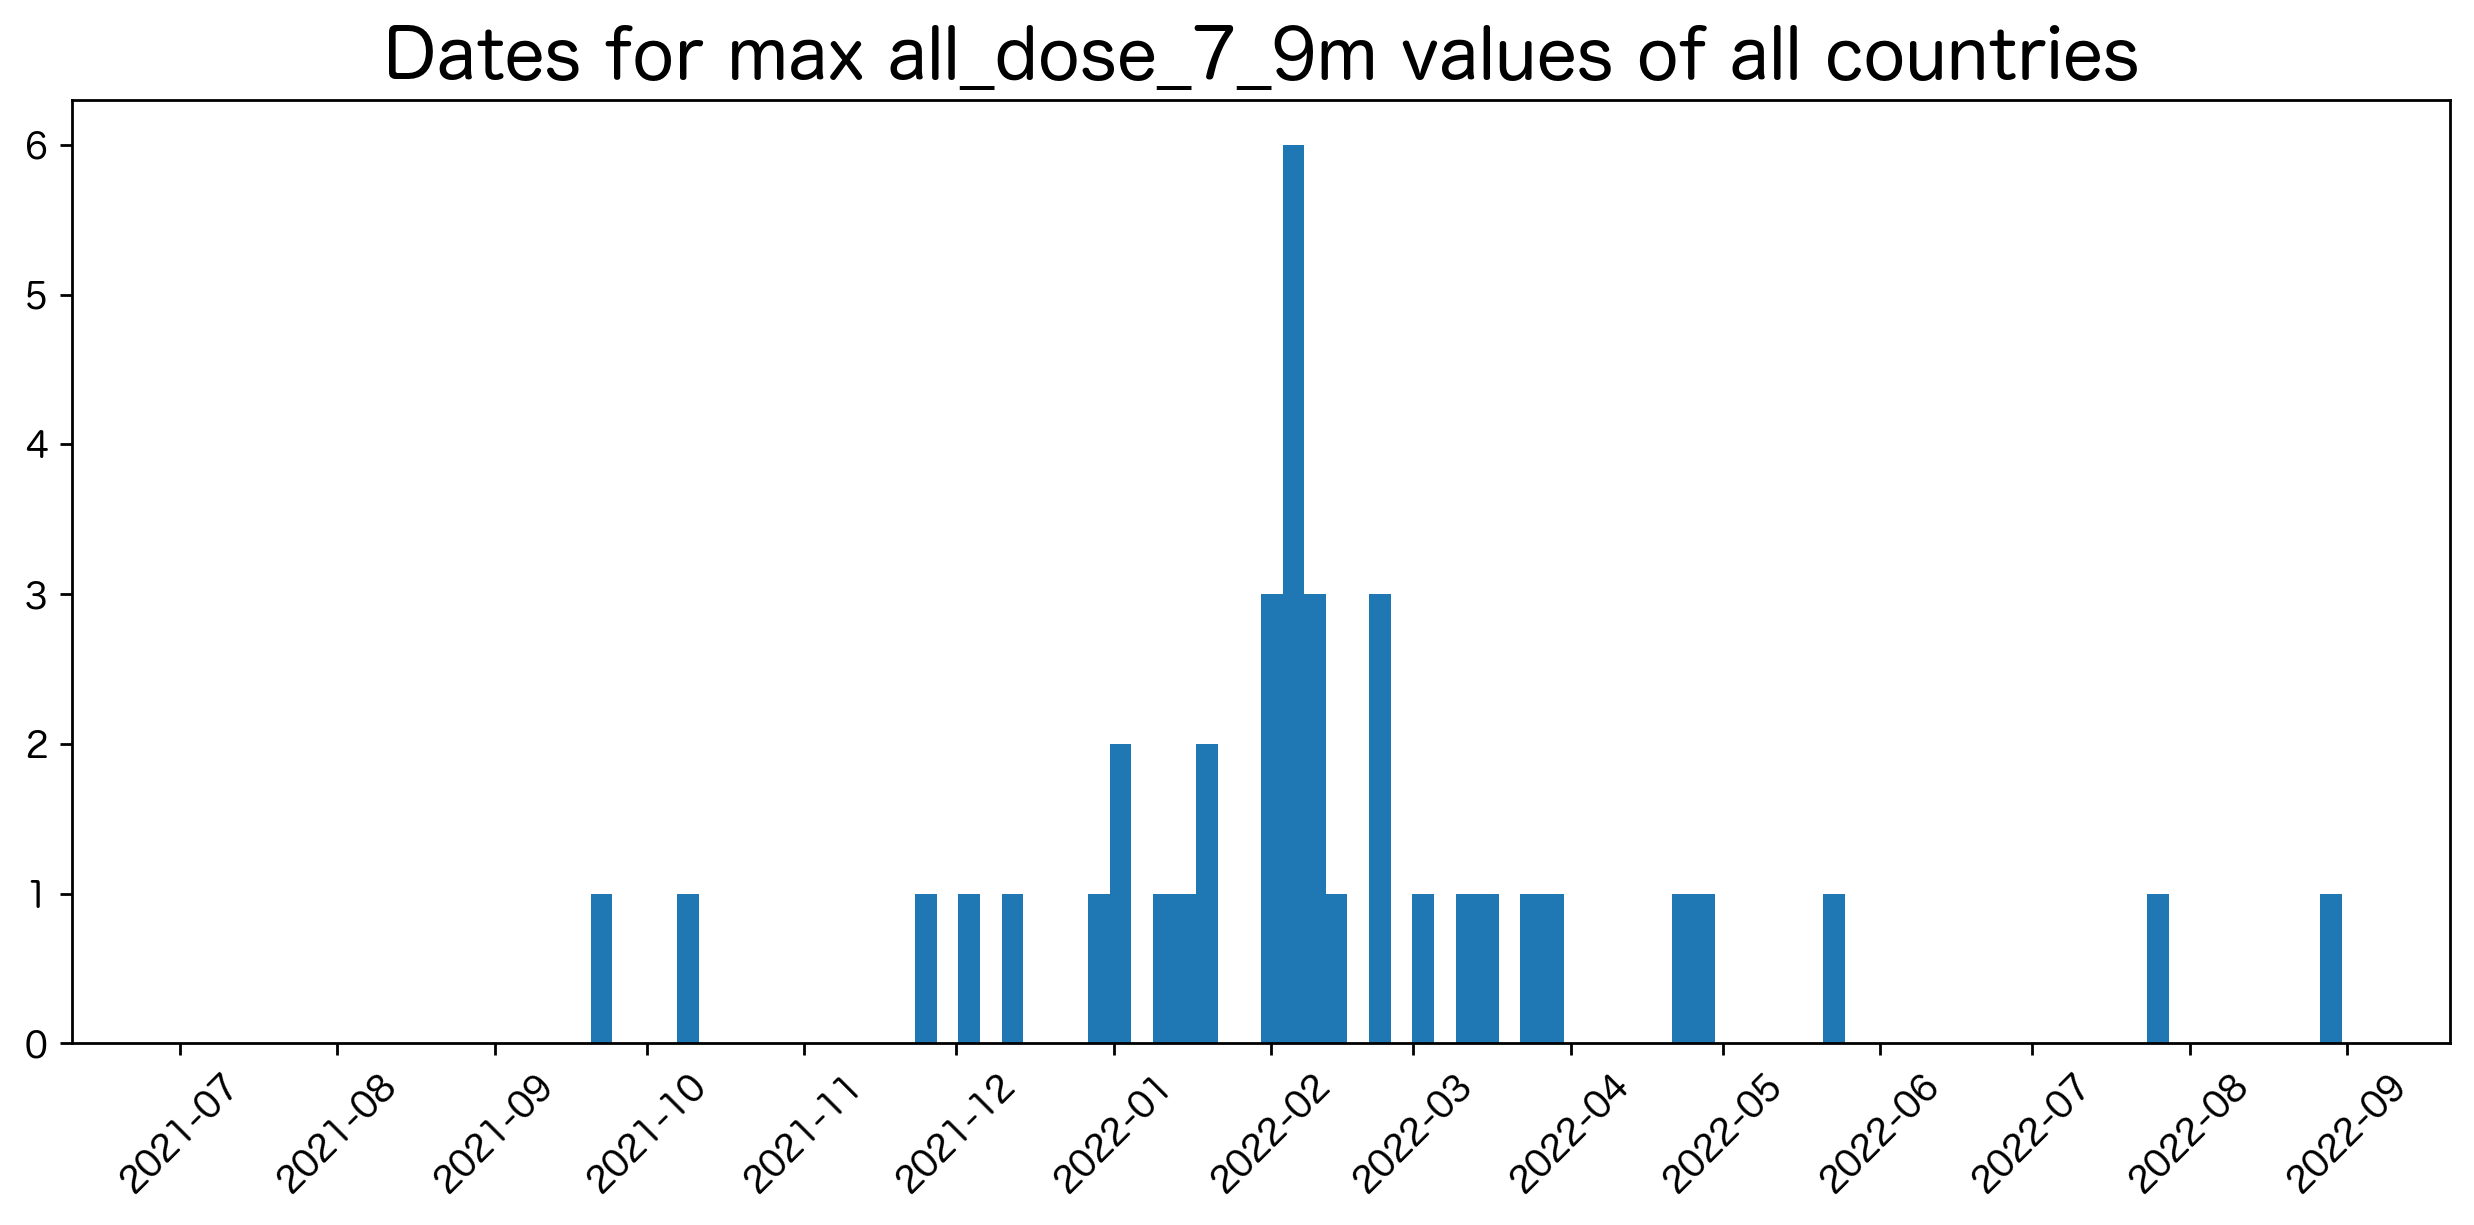

In [27]:
period='all_dose_7_9m'
tmp_lst=[]
for Countryname in new_join_df.location.unique():
    tmp_df=new_join_df[new_join_df['location']==Countryname].reset_index(drop=True)
    tmp_lst.append(tmp_df['date'].astype("datetime64").iloc[tmp_df[period].idxmax()])
    

fig,ax = plt.subplots()
fmt = mdates.MonthLocator(interval=1)

plt.hist(tmp_lst,bins=100,range=(datetime.strptime('2021-07-01','%Y-%m-%d'),datetime.strptime('2022-08-31','%Y-%m-%d')))
ax.xaxis.set_major_locator(fmt)
ax.tick_params(axis='x', labelrotation=45)
fig.set_dpi(250)
fig.set_size_inches(10,5)
plt.title('Dates for max {} values of all countries'.format(period),fontsize=20) 
plt.tight_layout()
fig.savefig('/'.join([save_path,'country_max_{}'.format(period)])+'.png',facecolor='white', transparent=False)

## Check where is all_dose_19_21m centered

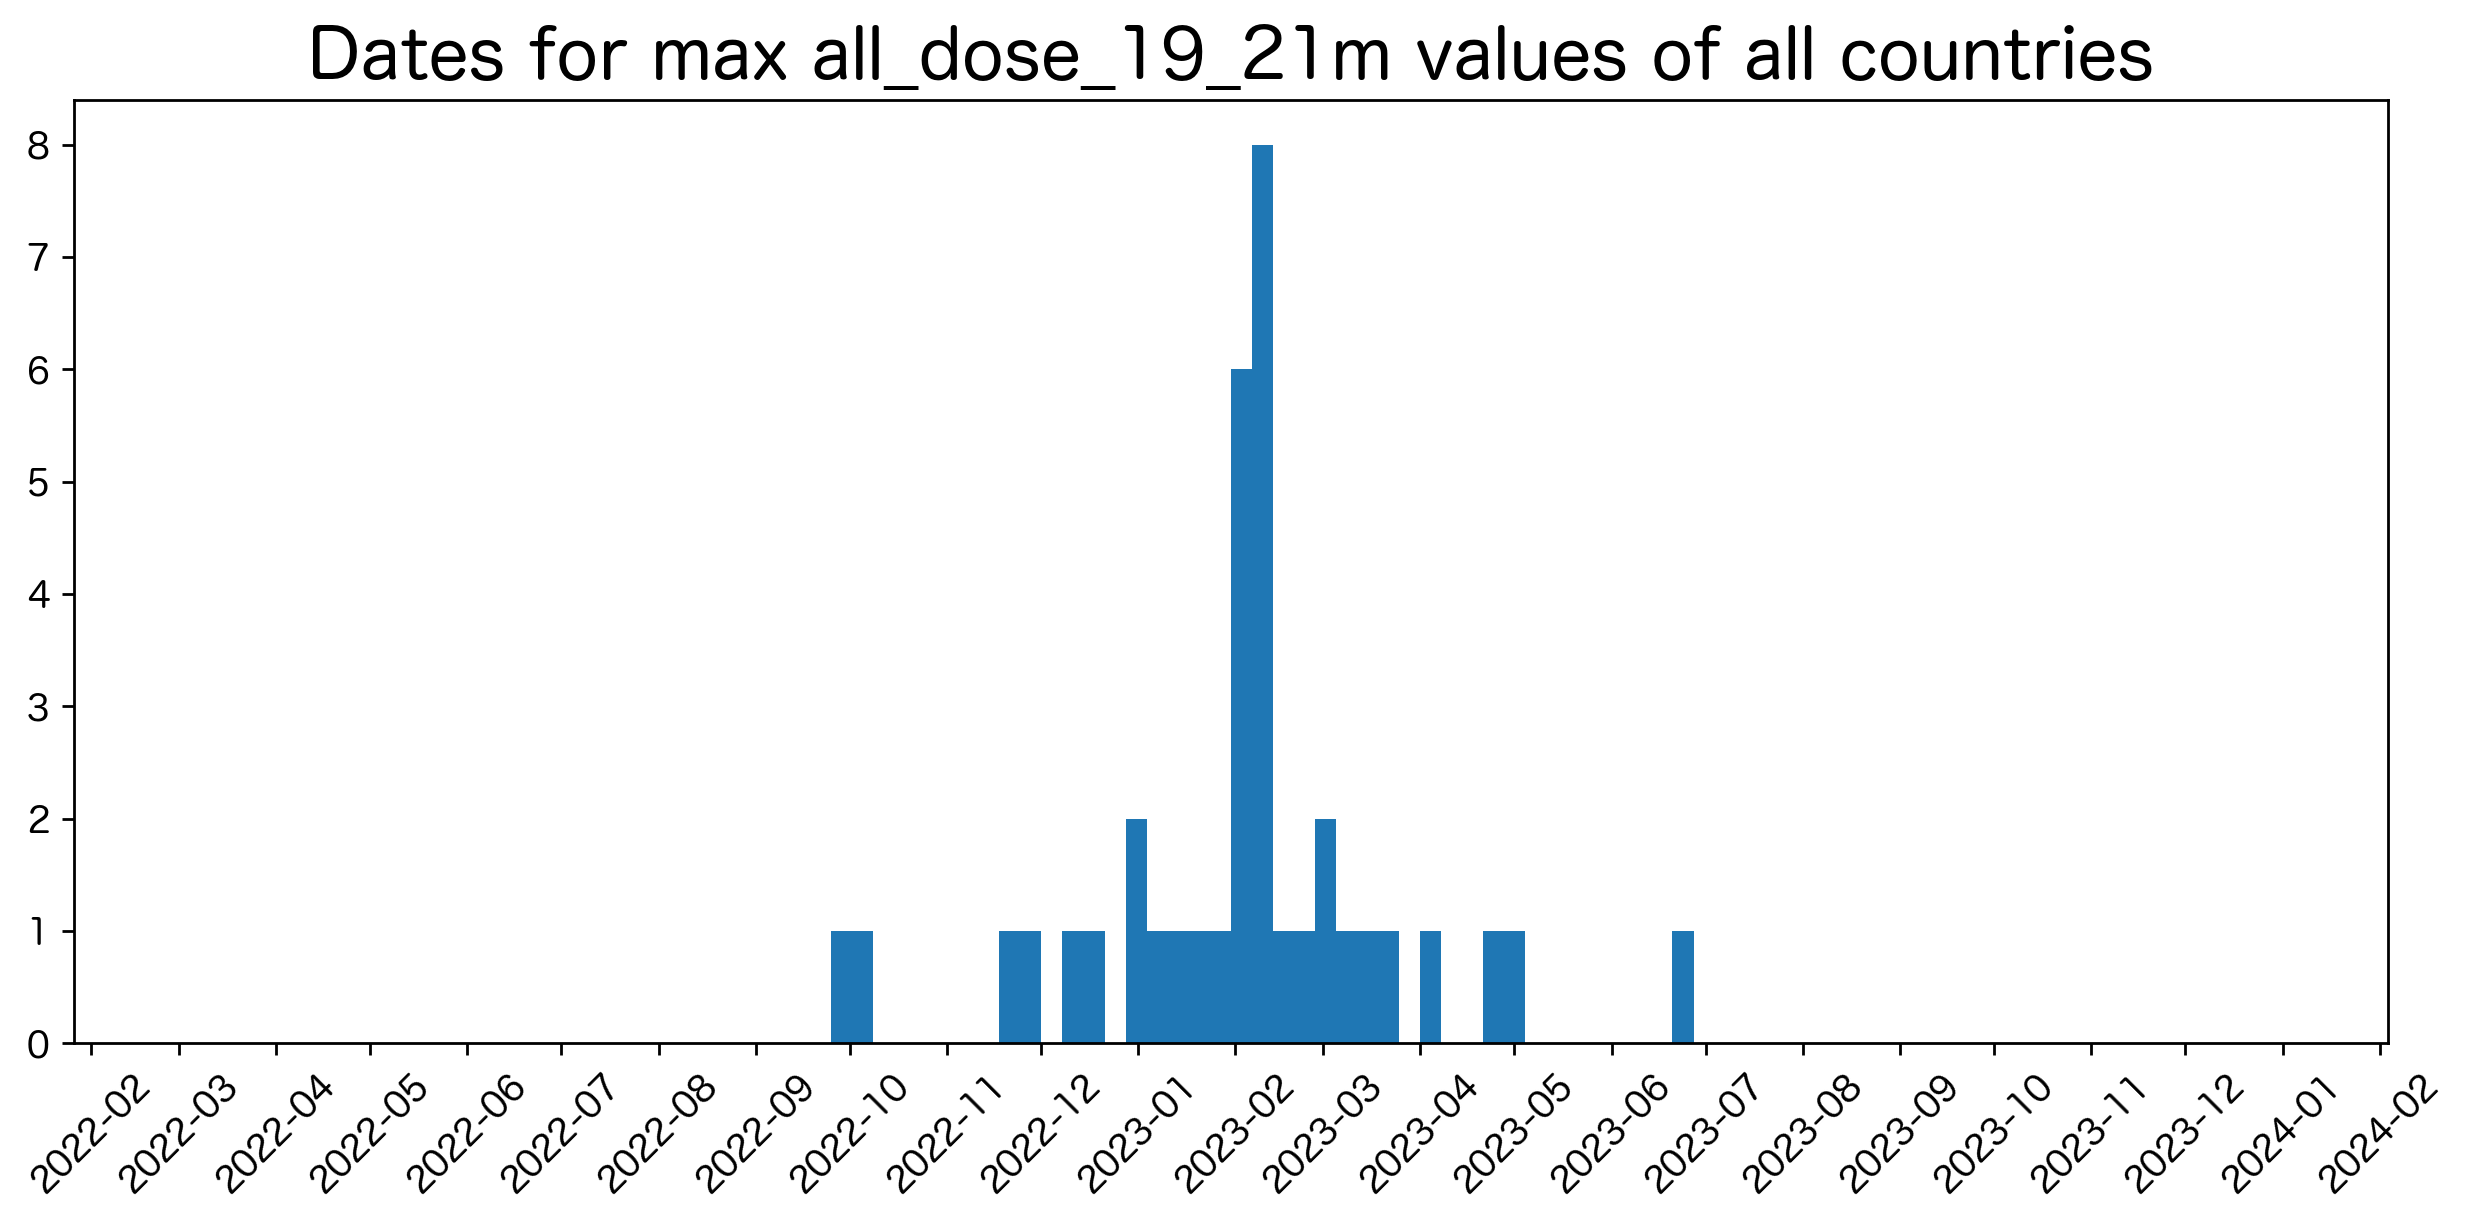

In [28]:
period='all_dose_19_21m'
tmp_lst=[]
for Countryname in new_join_df.location.unique():
    tmp_df=new_join_df[new_join_df['location']==Countryname].reset_index(drop=True)
    tmp_lst.append(tmp_df['date'].astype("datetime64").iloc[tmp_df[period].idxmax()])
    

fig,ax = plt.subplots()
fmt = mdates.MonthLocator(interval=1)

plt.hist(tmp_lst,bins=100,range=(datetime.strptime('2022-03-01','%Y-%m-%d'),datetime.strptime('2024-01-01','%Y-%m-%d')))
ax.xaxis.set_major_locator(fmt)
ax.tick_params(axis='x', labelrotation=45)
fig.set_dpi(250)
fig.set_size_inches(10,5)
plt.title('Dates for max {} values of all countries'.format(period),fontsize=20) 
plt.tight_layout()
fig.savefig('/'.join([save_path,'country_max_{}'.format(period)])+'.png',facecolor='white', transparent=False)



### Plot max of all_dose_7_9m

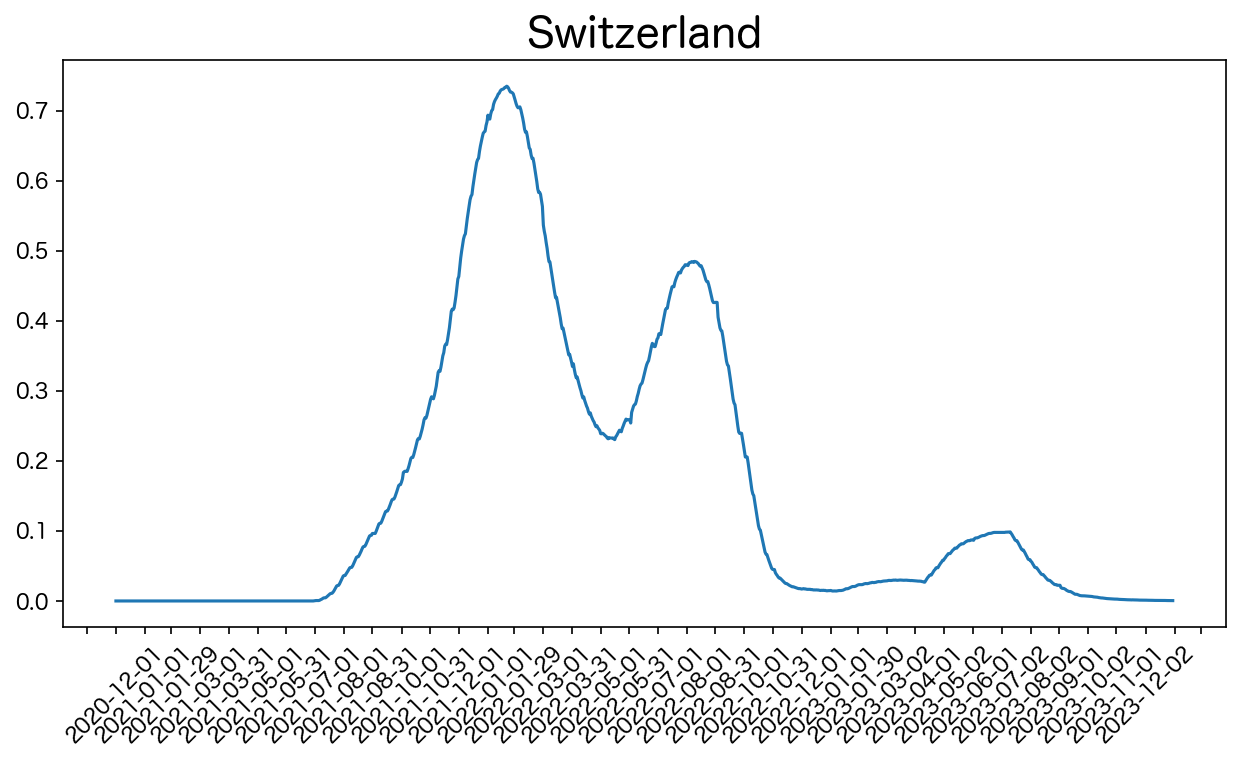

In [29]:
from matplotlib import pyplot as plt
#fmt
#plt.plot(tmp_df['date'].iloc[340:350],tmp_df['total_vaccinations_per_hundred'].iloc[340:350])
for Countryname in ['Switzerland']: #new_join_df.location.unique():
    tmp_df=new_join_df[new_join_df['location']==Countryname].reset_index(drop=True)
    for period in lst_dose_per[2:3]:
        #print(period)
        fig,ax = plt.subplots()
        fmt = mdates.MonthLocator(interval=1)
        plt.plot(tmp_df['date'],tmp_df[period])
        
        ax.xaxis.set_major_locator(fmt)
        ax.tick_params(axis='x', labelrotation=45)
        plt.title(Countryname,fontsize=20)
        fig.set_dpi(150)
        fig.set_size_inches(10,5)


## remove southern + equatorial countries

In [30]:
equatorial_countries=[ 'Fiji','Brazil', 'Colombia', 'Costa Rica', 'Cuba','Ecuador','Malaysia','Maldives','Panama',
                      'Peru','Singapore','Thailand','Hong Kong','Philippines'] #
south_countries=['Argentina','Uruguay','New Zealand','Australia','Paraguay','Chile'] #  

In [31]:
new_join_df = new_join_df[~new_join_df['location'].isin(equatorial_countries+south_countries)].reset_index(drop=True)

In [32]:
rm_countries_lst = ['Oman','Hungary','Kuwait','Iceland','Uzbekistan','Liechtenstein','Bermuda','Luxembourg','Aruba'] #'Oman','Hungary','Kuwait',
new_join_df = new_join_df[~new_join_df['location'].isin(rm_countries_lst)].reset_index(drop=True)

In [33]:
north_countries = [s for s in new_df_overall.location.unique() if s not in equatorial_countries + south_countries]

In [34]:
new_join_df = new_join_df[~new_join_df['location'].isin(['Kazakhstan'])].reset_index(drop=True)

### check # of countries using Weekly or Monthly update

In [35]:
tmp_lst = []
for Countryname in new_join_df.location.unique():
    per,cnt = np.unique(new_join_df[new_join_df['location']==Countryname]['excess_mortality'],return_counts=True)
    cnt_lst=list(set(cnt))
    tmp_lst.append((Countryname,cnt_lst))
print('Weekly : {}; Monthly : {}.'.format(len([x for x in tmp_lst if 7 in x[1]]),len([x for x in tmp_lst if 7 not in x[1]])))

Weekly : 26; Monthly : 3.


In [36]:
new_join_df.location.unique()

array(['Austria', 'Belgium', 'Canada', 'Cyprus', 'Czechia', 'Denmark',
       'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Iran',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Lithuania',
       'Netherlands', 'Norway', 'Portugal', 'South Korea', 'Spain',
       'Sweden', 'Switzerland', 'Turkey', 'United Arab Emirates',
       'United Kingdom', 'United States'], dtype=object)

### Model running

In [37]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] 

mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.506446
re_est_ex_mortality_Norm                  0.506446                  1.000000
[LR_MDL] Self-Rmse for All is : 0.03100047865446845
Self-R2 is : 0.25648743604391955
Cross-validataion R2 : [0.22478672 0.10893503 0.21706751 0.26766569 0.34325166].
Cross-validataion R2 average : 0.23234132310914318.
Cross-validataion R2 std : 0.07624747582425015.
Cross-validataion mse : [0.03239507719740717, 0.03065712002138007, 0.031153437372292606, 0.02961967605101235, 0.033190802761413334].
Cross-validataion mse average : 0.03140322268070111.
Cross-validataion mse std : 0.0012632749808403644.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0

### Use covid death + TPARDs + VA-PVP (no countriwise CV)

In [38]:
mdl_x_lst = lst_overall +lst_dose_per 
mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          all_dose_1_3m  all_dose_4_6m  all_dose_7_9m  \
all_dose_1_3m                  1.000000       0.470444       0.168031   
all_dose_4_6m                  0.470444       1.000000       0.469156   
all_dose_7_9m                  0.168031       0.469156       1.000000   
all_dose_10_12m               -0.153741       0.178861       0.471984   
all_dose_13_15m               -0.387722      -0.121162       0.214624   
all_dose_16_18m               -0.401534      -0.350477      -0.079172   
all_dose_19_21m               -0.418410      -0.357086      -0.307316   
all_dose_22_24m               -0.423186      -0.351318      -0.287347   
all_dose_25m+                 -0.342216      -0.330583      -0.275292   
re_est_ex_mortality_Norm       0.055074       0.141542       0.109013   

                          all_dose_10_12m  all_dose_13_15m  all_dose_16_18m  \
all_dose_1_3m                   -0.153741        -0.387722        -0.401534   
all_

In [39]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_overall 
mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.506446
re_est_ex_mortality_Norm                  0.506446                  1.000000
[LR_MDL] Self-Rmse for All is : 0.023700592318635284
Self-R2 is : 0.4315672232510419
Cross-validataion R2 : [0.40904555 0.28184367 0.31585795 0.48092256 0.46173449].
Cross-validataion R2 average : 0.38988084552052804.
Cross-validataion R2 std : 0.07870228071039306.
Cross-validataion mse : [0.02469515902090339, 0.02470819231259039, 0.027222495847313576, 0.020994381294365837, 0.027202907200627003].
Cross-validataion mse average : 0.024964627135160043.
Cross-validataion mse std : 0.0022807495562625762.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                 

### VA-PVP and COVID death

In [40]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_dose_per #lst_1dose+lst_2dose +lst_3dose #
#mdl_x_lst= ['new_deaths_smoothed_30d_Norm']+ lst_overall + lst_1dose+lst_2dose +lst_3dose


mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000       0.060970   
all_dose_1_3m                             0.060970       1.000000   
all_dose_4_6m                             0.037276       0.470444   
all_dose_7_9m                             0.132397       0.168031   
all_dose_10_12m                          -0.022731      -0.153741   
all_dose_13_15m                          -0.178760      -0.387722   
all_dose_16_18m                          -0.235273      -0.401534   
all_dose_19_21m                          -0.281694      -0.418410   
all_dose_22_24m                          -0.310115      -0.423186   
all_dose_25m+                            -0.277352      -0.342216   
re_est_ex_mortality_Norm                  0.506446       0.055074   

                          all_dose_4_6m  all_dose_7_9m  all_dose_10_12m  \
new_deaths_smoothed_Norm       0.037276       0.132397        

### VA-PVP, TPARD, and COVID death

In [41]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_overall + lst_dose_per

mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000       0.060970   
all_dose_1_3m                             0.060970       1.000000   
all_dose_4_6m                             0.037276       0.470444   
all_dose_7_9m                             0.132397       0.168031   
all_dose_10_12m                          -0.022731      -0.153741   
all_dose_13_15m                          -0.178760      -0.387722   
all_dose_16_18m                          -0.235273      -0.401534   
all_dose_19_21m                          -0.281694      -0.418410   
all_dose_22_24m                          -0.310115      -0.423186   
all_dose_25m+                            -0.277352      -0.342216   
re_est_ex_mortality_Norm                  0.506446       0.055074   

                          all_dose_4_6m  all_dose_7_9m  all_dose_10_12m  \
new_deaths_smoothed_Norm       0.037276       0.132397        

### Added PFE

In [42]:
pfe_lst = ['last_year_new_deaths_smoothed_1_3m_Norm','last_year_new_deaths_smoothed_4_6m_Norm','last_year_new_deaths_smoothed_7_9m_Norm','last_year_new_deaths_smoothed_10_12m_Norm','last_year_new_deaths_smoothed_13_15m_Norm'] 

In [43]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_dose_per + pfe_lst[:1] ## lst_1dose + lst_2dose + lst_3dose 
#mdl_x_lst= ['new_deaths_smoothed_30d_Norm']+ lst_overall + lst_1dose+lst_2dose +lst_3dose


mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
all_dose_1_3m                                            0.060970   
all_dose_4_6m                                            0.037276   
all_dose_7_9m                                            0.132397   
all_dose_10_12m                                         -0.022731   
all_dose_13_15m                                         -0.178760   
all_dose_16_18m                                         -0.235273   
all_dose_19_21m                                         -0.281694   
all_dose_22_24m                                         -0.310115   
all_dose_25m+                                           -0.277352   
last_year_new_deaths_smoothed_1_3m_Norm                  0.656044   
re_est_ex_mortality_Norm                                 0.506446   

                                         all_dose_1_3m  all_dose_4_6

In [44]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] +lst_overall + pfe_lst[:1] #lst_1dose+lst_2dose +lst_3dose #
#mdl_x_lst= ['new_deaths_smoothed_30d_Norm']+ lst_overall + lst_1dose+lst_2dose +lst_3dose


mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.656044   
re_est_ex_mortality_Norm                                 0.506446   

                                         last_year_new_deaths_smoothed_1_3m_Norm  \
new_deaths_smoothed_Norm                                                0.656044   
last_year_new_deaths_smoothed_1_3m_Norm                                 1.000000   
re_est_ex_mortality_Norm                                                0.137669   

                                         re_est_ex_mortality_Norm  
new_deaths_smoothed_Norm                                 0.506446  
last_year_new_deaths_smoothed_1_3m_Norm                  0.137669  
re_est_ex_mortality_Norm                                 1.000000  
[LR_MDL] Self-Rmse for All is : 0.023093728604540856
Self-R2 is : 0.446122185484

In [45]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] +lst_overall + lst_dose_per + pfe_lst[:1] #lst_1dose+lst_2dose +lst_3dose #
#mdl_x_lst= ['new_deaths_smoothed_30d_Norm']+ lst_overall + lst_1dose+lst_2dose +lst_3dose


mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
all_dose_1_3m                                            0.060970   
all_dose_4_6m                                            0.037276   
all_dose_7_9m                                            0.132397   
all_dose_10_12m                                         -0.022731   
all_dose_13_15m                                         -0.178760   
all_dose_16_18m                                         -0.235273   
all_dose_19_21m                                         -0.281694   
all_dose_22_24m                                         -0.310115   
all_dose_25m+                                           -0.277352   
last_year_new_deaths_smoothed_1_3m_Norm                  0.656044   
re_est_ex_mortality_Norm                                 0.506446   

                                         all_dose_1_3m  all_dose_4_6

In [46]:
res_df

,params,linear_weights,p_value
0,new_deaths_smoothed_Norm,0.746978,0.000000
1,overall_1_3m,-0.113959,0.000000
2,overall_4_6m,-0.027098,0.122505
3,overall_7_9m,-0.013059,0.522296
4,overall_10_12m,-0.063917,0.003151
5,overall_13_15m,-0.263058,0.000000
6,overall_16_18m,-0.178765,0.000000
7,overall_19_21m,-0.195798,0.000000
8,overall_22_24m,-0.181448,0.000000
9,overall_25_27m,-0.400926,0.000000


### plot coefficients

['all_dose_1_3m', 'all_dose_4_6m', 'all_dose_7_9m', 'all_dose_10_12m', 'all_dose_13_15m', 'all_dose_16_18m', 'all_dose_19_21m', 'all_dose_22_24m', 'all_dose_25m+']
['2020_Winter', '2021_Spring', '2021_Summer', '2021_Fall', '2021_Winter', '2022_Spring', '2022_Summer', '2022_Fall', '2022_Winter', '2023_Spring', '2023_Summer']


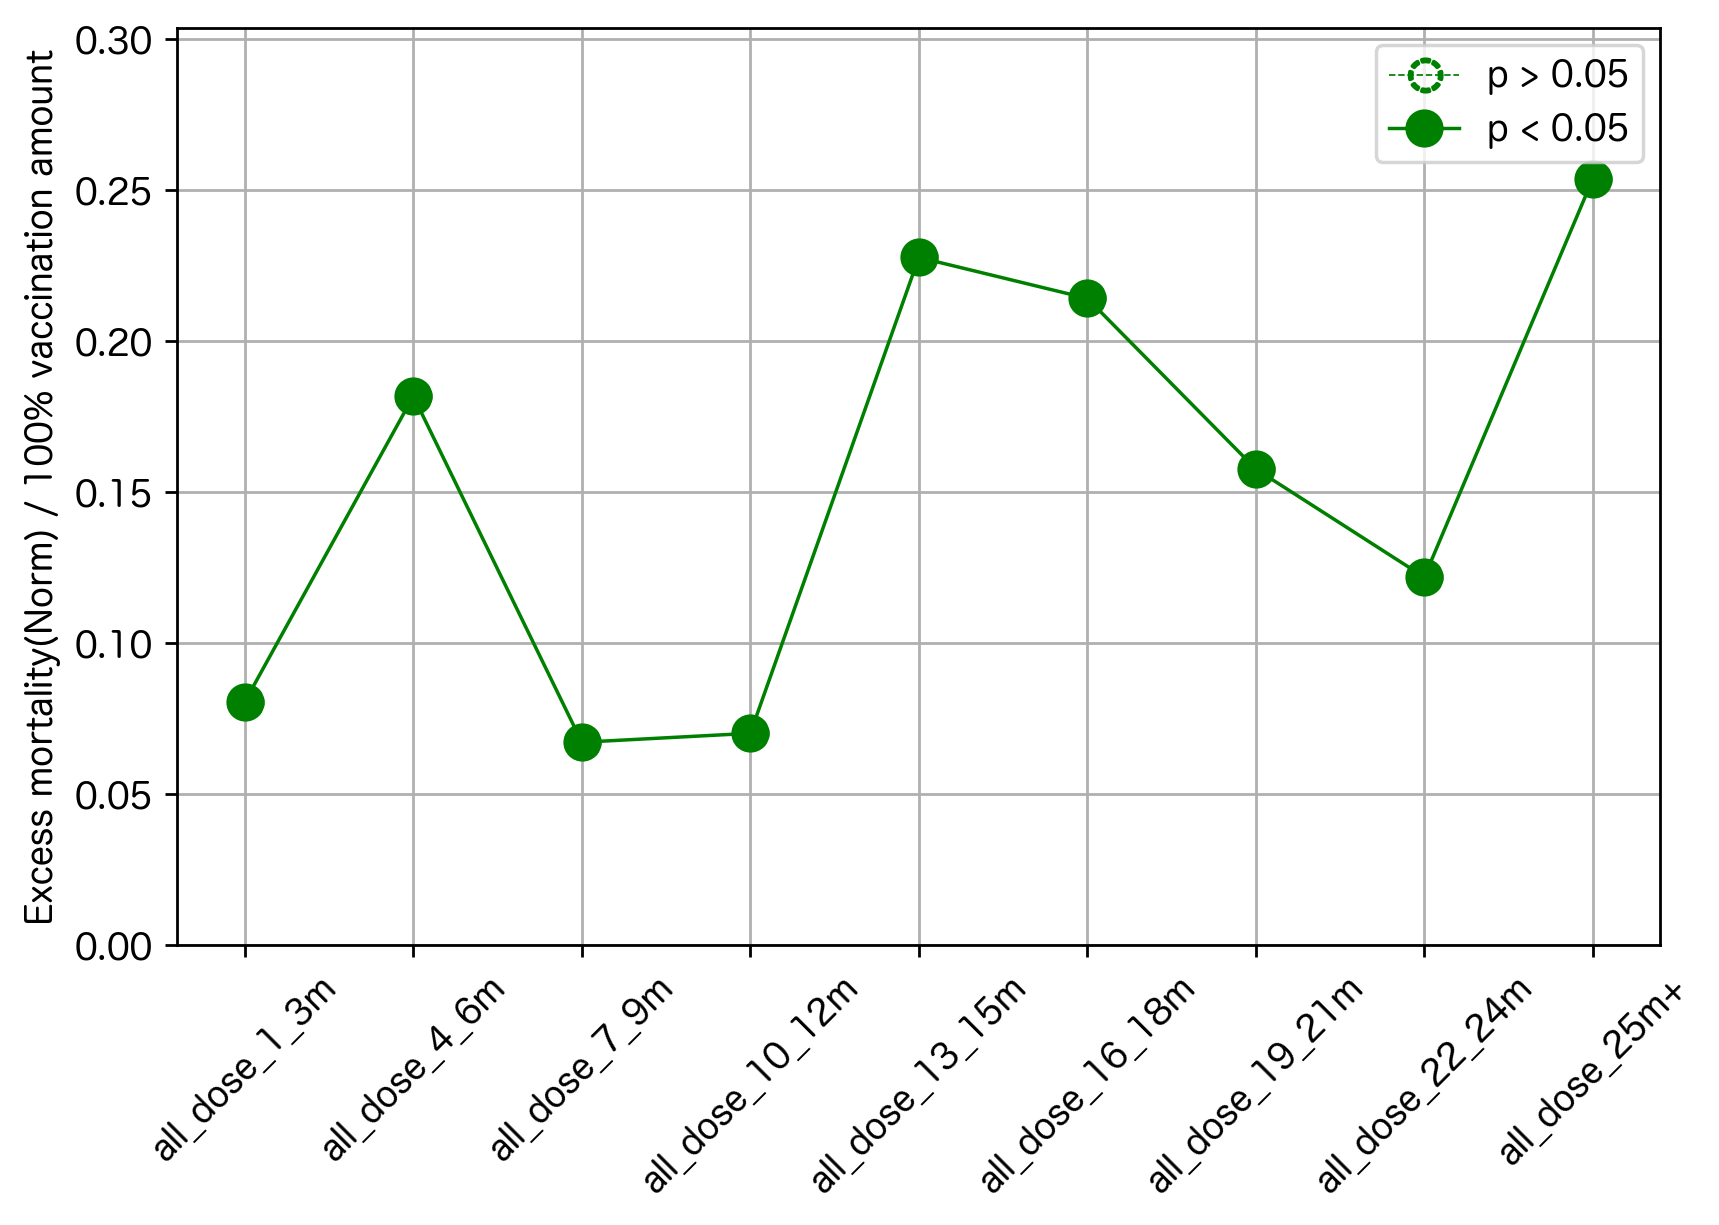

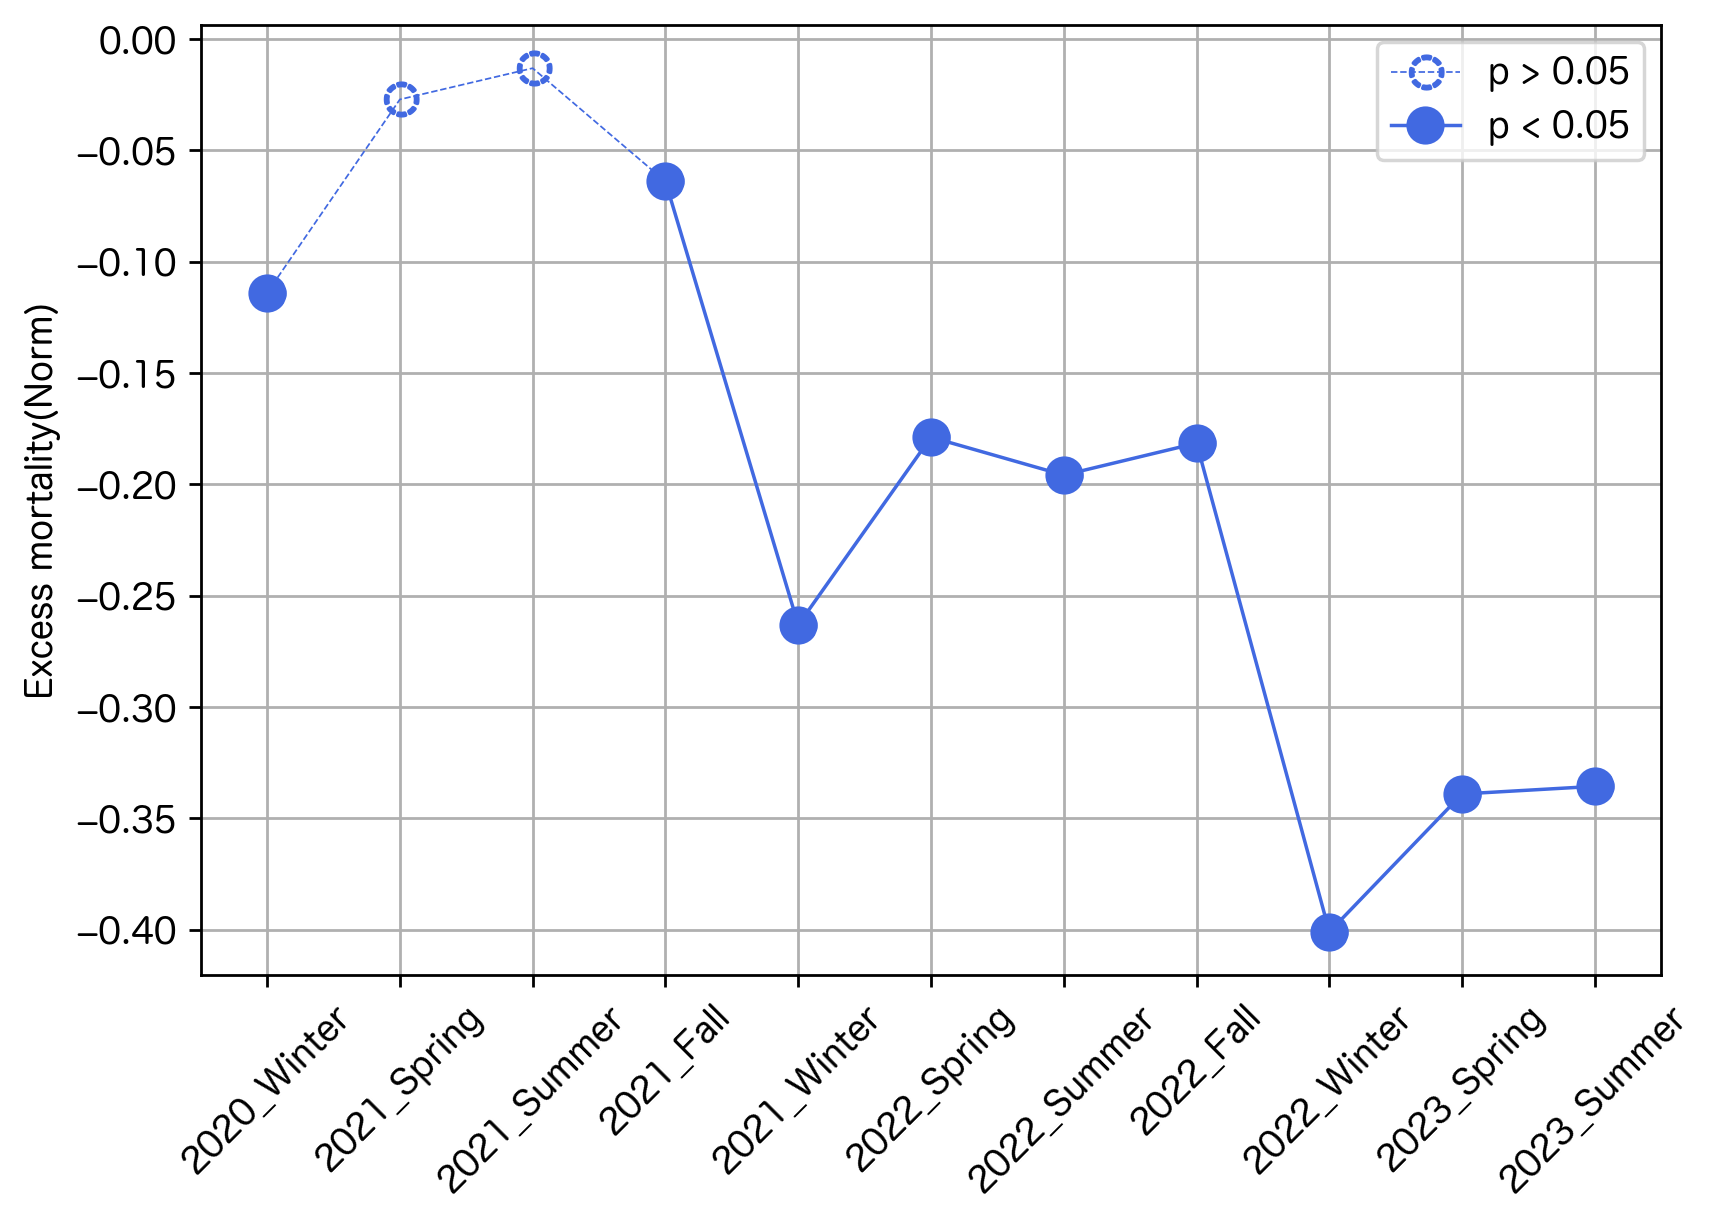

In [47]:
res_df['p005_linear_weights']=res_df['linear_weights']
res_df.loc[res_df['p_value'] > 0.05, 'p005_linear_weights'] = np.NAN
save_path = 'results_north_0218_fix_Isa'
os.makedirs(save_path,exist_ok=True)

l_all,l_vax=len(lst_overall) ,len(lst_dose_per)
#
outfile = '/'.join([save_path,'sum_all_dose_coefs.png'])
x_lst = res_df['params'].iloc[l_all+1:-1].tolist()
y_dot_lst = res_df['linear_weights'].iloc[l_all+1:-1].tolist()
y_solid_lst = res_df['p005_linear_weights'].iloc[l_all+1:-1]

plt_curve_by_pvalue_vax(x_lst,y_dot_lst,y_solid_lst,outfile,color='green')

#
outfile = '/'.join([save_path,'sum_all_dose_overall_coefs.png'])
season_data_lst = ['2020_Winter',
'2021_Spring',
'2021_Summer',
'2021_Fall',
'2021_Winter',
'2022_Spring',
'2022_Summer',
'2022_Fall',
'2022_Winter',
'2023_Spring',
'2023_Summer']#,
#'2023_Fall~'
y_dot_lst = res_df['linear_weights'].iloc[1:l_all+1].tolist()
y_solid_lst = res_df['p005_linear_weights'].iloc[1:l_all+1]

plt_curve_by_pvalue_tpard(season_data_lst[:l_all],y_dot_lst,y_solid_lst,outfile)




# Comparison between excess mortality caused by COVID death and VA-PVPs

### Average daily, country-wise

In [49]:
lst1=[]
lst2=[]
s_e=(12,21)
for Countryname in new_join_df['location'].unique():
    #print(Countryname)
    tmp_covid, tmp_vax = cal_ex_death_by_covid_vax_mean(new_join_df,lr_mdl,Countryname,mdl_x_lst,s_e,'2020-12-01')
    lst1.append(tmp_covid)
    lst2.append(tmp_vax)
print('COVID death : {}\nVA-TPAVs : {}\n'.format(np.mean(lst1),np.mean(lst2)))

COVID death : 0.1320647201203516
VA-TPAVs : 0.2256114851818739



### Most Current day

In [50]:
lst1=[]
lst2=[]
s_e=(12,21)
for Countryname in new_join_df['location'].unique():
    #print(Countryname)
    tmp_covid, tmp_vax = cal_ex_death_by_covid_vax(new_join_df,lr_mdl,Countryname,mdl_x_lst,s_e,'2020-12-01')
    lst1.append(tmp_covid)
    lst2.append(tmp_vax)
print('COVID death : {}\nVA-TPAVs : {}\n'.format(np.mean(lst1),np.mean(lst2)))

COVID death : 0.1320647201203516
VA-TPAVs : 0.4485079050767218



### 2.5% and 97.5% level of reg coefs

In [51]:
v_conf_int=lr_mdl.conf_int()

### 2.5% ~ 97.5% mean effect 

In [52]:
def cal_ex_death_by_covid_mean_vax_conf_int(df,lr_mdl,Countryname,v_conf_int,mdl_x_lst,s_e,start_date):
    v_conf_int_lo = [x[0] for x in v_conf_int]
    v_conf_int_hi = [x[1] for x in v_conf_int]
    vax_var_lst=mdl_x_lst[s_e[0]:s_e[1]]
    tmp_df = df[df['location']==Countryname].reset_index(drop=True)
    tmp_df = tmp_df[tmp_df['date']>=start_date].reset_index(drop=True)
    ex_death_covid_lo = tmp_df['new_deaths_smoothed'].mean()/tmp_df['new_deaths_smoothed'].max()*v_conf_int_lo[1]
    ex_death_covid_hi = tmp_df['new_deaths_smoothed'].mean()/tmp_df['new_deaths_smoothed'].max()*v_conf_int_hi[1]

    #x = tmp_df.iloc[-1][vax_var_lst].values.astype('float64')
    x = tmp_df.loc[tmp_df[vax_var_lst[0]] > 0][vax_var_lst].values.astype('float64')
    ex_death_vax_lo = np.dot(x,v_conf_int_lo[s_e[0]+1:s_e[1]+1]).mean()
    ex_death_vax_hi = np.dot(x,v_conf_int_hi[s_e[0]+1:s_e[1]+1]).mean()

    
    return ex_death_covid_lo,ex_death_covid_hi,ex_death_vax_lo,ex_death_vax_hi

In [53]:
lst1_lo=[]
lst1_hi=[]
lst2_lo=[]
lst2_hi=[]
s_e=(12,21)
for Countryname in new_join_df['location'].unique():
    #print(Countryname)
    tmp_covid_lo, tmp_covid_hi, tmp_vax_lo, tmp_vax_hi = cal_ex_death_by_covid_mean_vax_conf_int(new_join_df,lr_mdl,Countryname,v_conf_int,mdl_x_lst,s_e,'2020-12-01')
    lst1_lo.append(tmp_covid_lo)
    lst1_hi.append(tmp_covid_hi)
    lst2_lo.append(tmp_vax_lo)
    lst2_hi.append(tmp_vax_hi)

print('COVID death : ({},{})\nVA-PVPs : ({},{})\n'.format(np.mean(lst1_lo),np.mean(lst1_hi),np.mean(lst2_lo),np.mean(lst2_hi)))

COVID death : (0.12665241310388853,0.13747702713681462)
VA-PVPs : (0.1666770370656352,0.2845459332981127)



### 2.5% ~ 97.5% lastday effect 

In [54]:
def cal_ex_death_by_covid_vax_conf_int(df,lr_mdl,Countryname,v_conf_int,mdl_x_lst,s_e,start_date):
    v_conf_int_lo = [x[0] for x in v_conf_int]
    v_conf_int_hi = [x[1] for x in v_conf_int]
    vax_var_lst=mdl_x_lst[s_e[0]:s_e[1]]
    tmp_df = df[df['location']==Countryname].reset_index(drop=True)
    tmp_df = tmp_df[tmp_df['date']>=start_date].reset_index(drop=True)
    ex_death_covid_lo = tmp_df['new_deaths_smoothed'].mean()/tmp_df['new_deaths_smoothed'].max()*v_conf_int_lo[1]
    ex_death_covid_hi = tmp_df['new_deaths_smoothed'].mean()/tmp_df['new_deaths_smoothed'].max()*v_conf_int_hi[1]

    #x = tmp_df.iloc[-1][vax_var_lst].values.astype('float64')
    x = tmp_df.loc[tmp_df[vax_var_lst[0]] > 0][vax_var_lst].values[-1].astype('float64')
    ex_death_vax_lo = np.dot(x,v_conf_int_lo[s_e[0]+1:s_e[1]+1]).mean()
    ex_death_vax_hi = np.dot(x,v_conf_int_hi[s_e[0]+1:s_e[1]+1]).mean()

    
    return ex_death_covid_lo,ex_death_covid_hi,ex_death_vax_lo,ex_death_vax_hi

In [55]:
lst1_lo=[]
lst1_hi=[]
lst2_lo=[]
lst2_hi=[]
s_e=(12,21)
for Countryname in new_join_df['location'].unique():
    #print(Countryname)
    tmp_covid_lo, tmp_covid_hi, tmp_vax_lo, tmp_vax_hi = cal_ex_death_by_covid_vax_conf_int(new_join_df,lr_mdl,Countryname,v_conf_int,mdl_x_lst,s_e,'2020-12-01')
    lst1_lo.append(tmp_covid_lo)
    lst1_hi.append(tmp_covid_hi)
    lst2_lo.append(tmp_vax_lo)
    lst2_hi.append(tmp_vax_hi)

print('COVID death : ({},{})\nVA-PVPs : ({},{})\n'.format(np.mean(lst1_lo),np.mean(lst1_hi),np.mean(lst2_lo),np.mean(lst2_hi)))

COVID death : (0.12665241310388853,0.13747702713681462)
VA-PVPs : (0.32965339973203883,0.5143264707044037)



# Country wise 5-fold cv 

In [56]:
new_join_df.location.unique().shape,new_join_df.date.max()

((29,), '2023-12-31')

In [57]:
import random
import math
import copy

country_lst_shuffle = new_join_df['location'].unique()

n_cv = 5
n_per_split = math.ceil(len(country_lst_shuffle)/n_cv)
#random.Random(111).shuffle(country_lst_shuffle)
random.Random(222).shuffle(country_lst_shuffle)
#random.Random(333).shuffle(country_lst_shuffle)
#random.Random(444).shuffle(country_lst_shuffle)
#random.Random(555).shuffle(country_lst_shuffle)
#random.Random(666).shuffle(country_lst_shuffle)
#random.Random(777).shuffle(country_lst_shuffle)
#random.Random(888).shuffle(country_lst_shuffle)
#random.Random(999).shuffle(country_lst_shuffle)
#random.Random(0).shuffle(country_lst_shuffle)

country_lst_shuffle_cv = []
i=0
for x in range(n_cv-1):
    tmp_lst = country_lst_shuffle.tolist()[i:i+n_per_split]
    country_lst_shuffle_cv.append(tmp_lst)
    i = i + n_per_split

country_lst_shuffle_cv.append(country_lst_shuffle.tolist()[i:])

print(country_lst_shuffle_cv)

###############################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] #+ lst_overall + lst_1dose+lst_2dose+lst_3dose  #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')

r2_lst_cov_death=copy.deepcopy(r2_lst)
##############################################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] + lst_overall #+ lst_1dose+lst_2dose+lst_3dose  #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_tpard = copy.deepcopy(r2_lst)
######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] + lst_dose_per # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)

print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_sum_d_per=copy.deepcopy(r2_lst)

######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] + pfe_lst[:1] # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_pfe=copy.deepcopy(r2_lst)
######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm']+ lst_overall + lst_dose_per # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_tpard_sum_d_per=copy.deepcopy(r2_lst)

######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm']  + pfe_lst[:1] + lst_dose_per # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_pfe_sum_d_per=copy.deepcopy(r2_lst)
######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm']+ lst_overall + pfe_lst[:1] # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_tpard_pfe=copy.deepcopy(r2_lst)
######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm']+ lst_overall + lst_dose_per + pfe_lst[:1] # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_tpard_pfe_sum_d_per=copy.deepcopy(r2_lst)



[['South Korea', 'United States', 'Israel', 'Latvia', 'Czechia', 'Ireland'], ['Iran', 'Denmark', 'United Kingdom', 'France', 'Greece', 'Portugal'], ['Lithuania', 'Estonia', 'Sweden', 'Spain', 'Canada', 'Netherlands'], ['Norway', 'Italy', 'United Arab Emirates', 'Japan', 'Austria', 'Belgium'], ['Turkey', 'Germany', 'Finland', 'Cyprus', 'Switzerland']]
Testset countryname:['South Korea', 'United States', 'Israel', 'Latvia', 'Czechia', 'Ireland']
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.456971
re_est_ex_mortality_Norm                  0.456971                  1.000000
[LR_MDL] Intercept is : 0.307329
LR model coeffecients.
                     params  linear_weights  p_value
0  new_deaths_smoothed_Norm         0.42879      0.0
['South Korea', 'United States', 'Israel', 'Latvia', 'Czechia', 'Ireland'] 
R2: 0.27544079423785484
Testset countryname:['Iran', 'Denmark', 'United Kingdom', '

[LR_MDL] Intercept is : 0.193644
LR model coeffecients.
                      params  linear_weights   p_value
0   new_deaths_smoothed_Norm        0.676979  0.000000
1               overall_1_3m       -0.127639  0.000000
2               overall_4_6m        0.011708  0.533626
3               overall_7_9m        0.130411  0.000000
4             overall_10_12m        0.119115  0.000000
5             overall_13_15m       -0.071927  0.000096
6             overall_16_18m        0.078057  0.000044
7             overall_19_21m        0.149841  0.000000
8             overall_22_24m        0.190716  0.000000
9             overall_25_27m       -0.007799  0.687250
10            overall_28_30m        0.074079  0.000169
11              overall_31m+        0.142068  0.000000
['Turkey', 'Germany', 'Finland', 'Cyprus', 'Switzerland'] 
R2: 0.4702869263499715
Mean R2: 0.3195111660891775
Std R2: 0.13703210937022398
Testset countryname:['South Korea', 'United States', 'Israel', 'Latvia', 'Czechia', 'Irelan

[LR_MDL] Intercept is : 0.106107
LR model coeffecients.
                     params  linear_weights   p_value
0  new_deaths_smoothed_Norm        0.663168  0.000000
1             all_dose_1_3m        0.149160  0.000000
2             all_dose_4_6m        0.261179  0.000000
3             all_dose_7_9m       -0.070450  0.000004
4           all_dose_10_12m       -0.027965  0.072012
5           all_dose_13_15m        0.174376  0.000000
6           all_dose_16_18m        0.276456  0.000000
7           all_dose_19_21m       -0.029483  0.069546
8           all_dose_22_24m       -0.097153  0.000000
9             all_dose_25m+        0.200800  0.000000
['Iran', 'Denmark', 'United Kingdom', 'France', 'Greece', 'Portugal'] 
R2: 0.1564320308872702
Testset countryname:['Lithuania', 'Estonia', 'Sweden', 'Spain', 'Canada', 'Netherlands']
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000       0.080062   
all_dose_1_3m                

[LR_MDL] Intercept is : 0.134303
LR model coeffecients.
                     params  linear_weights   p_value
0  new_deaths_smoothed_Norm        0.619128  0.000000
1             all_dose_1_3m        0.076820  0.000002
2             all_dose_4_6m        0.238770  0.000000
3             all_dose_7_9m       -0.052909  0.000551
4           all_dose_10_12m       -0.059664  0.000111
5           all_dose_13_15m        0.120845  0.000000
6           all_dose_16_18m        0.248274  0.000000
7           all_dose_19_21m        0.000431  0.978973
8           all_dose_22_24m       -0.133533  0.000000
9             all_dose_25m+        0.162822  0.000000
['Norway', 'Italy', 'United Arab Emirates', 'Japan', 'Austria', 'Belgium'] 
R2: 0.20510604106378383
Testset countryname:['Turkey', 'Germany', 'Finland', 'Cyprus', 'Switzerland']
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000       0.044112   
all_dose_1_3m                     

[LR_MDL] Intercept is : 0.309002
LR model coeffecients.
                                    params  linear_weights  p_value
0                 new_deaths_smoothed_Norm        0.701874      0.0
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.350964      0.0
['Lithuania', 'Estonia', 'Sweden', 'Spain', 'Canada', 'Netherlands'] 
R2: 0.2829623650866335
Testset countryname:['Norway', 'Italy', 'United Arab Emirates', 'Japan', 'Austria', 'Belgium']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.649070   
re_est_ex_mortality_Norm                                 0.552382   

                                         last_year_new_deaths_smoothed_1_3m_Norm  \
new_deaths_smoothed_Norm                                                0.649070   
last_year_new_deaths_smoothed_1_3m_Norm                                 1.000000   
re_est_ex_mortality_Nor

['South Korea', 'United States', 'Israel', 'Latvia', 'Czechia', 'Ireland'] 
R2: 0.4322774148398685
Testset countryname:['Iran', 'Denmark', 'United Kingdom', 'France', 'Greece', 'Portugal']
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000       0.063796   
all_dose_1_3m                             0.063796       1.000000   
all_dose_4_6m                             0.058260       0.472211   
all_dose_7_9m                             0.146022       0.175487   
all_dose_10_12m                          -0.010036      -0.149128   
all_dose_13_15m                          -0.173131      -0.388519   
all_dose_16_18m                          -0.227323      -0.404746   
all_dose_19_21m                          -0.277104      -0.418488   
all_dose_22_24m                          -0.309054      -0.421159   
all_dose_25m+                            -0.275275      -0.341037   
re_est_ex_mortality_Norm                  0.526124  

[LR_MDL] Intercept is : 0.220641
LR model coeffecients.
                      params  linear_weights   p_value
0   new_deaths_smoothed_Norm        0.649022  0.000000
1               overall_1_3m       -0.143894  0.000000
2               overall_4_6m       -0.066579  0.000844
3               overall_7_9m       -0.043450  0.060751
4             overall_10_12m       -0.124354  0.000001
5             overall_13_15m       -0.337029  0.000000
6             overall_16_18m       -0.283801  0.000000
7             overall_19_21m       -0.282601  0.000000
8             overall_22_24m       -0.277387  0.000000
9             overall_25_27m       -0.507619  0.000000
10            overall_28_30m       -0.450612  0.000000
11              overall_31m+       -0.442827  0.000000
12             all_dose_1_3m        0.084509  0.000015
13             all_dose_4_6m        0.221863  0.000000
14             all_dose_7_9m        0.104527  0.000000
15           all_dose_10_12m        0.099787  0.000001
16       

[LR_MDL] Intercept is : 0.186556
LR model coeffecients.
                      params  linear_weights   p_value
0   new_deaths_smoothed_Norm        0.692243  0.000000
1               overall_1_3m       -0.133058  0.000000
2               overall_4_6m       -0.028569  0.137416
3               overall_7_9m        0.006145  0.782704
4             overall_10_12m       -0.062575  0.007776
5             overall_13_15m       -0.258195  0.000000
6             overall_16_18m       -0.174531  0.000000
7             overall_19_21m       -0.148779  0.000000
8             overall_22_24m       -0.128889  0.000011
9             overall_25_27m       -0.351325  0.000000
10            overall_28_30m       -0.276355  0.000000
11              overall_31m+       -0.261188  0.000000
12             all_dose_1_3m        0.060147  0.001392
13             all_dose_4_6m        0.214723  0.000000
14             all_dose_7_9m        0.064319  0.000647
15           all_dose_10_12m        0.051464  0.007583
16       

[LR_MDL] Intercept is : 0.151758
LR model coeffecients.
                                     params  linear_weights   p_value
0                  new_deaths_smoothed_Norm        0.769170  0.000000
1   last_year_new_deaths_smoothed_1_3m_Norm       -0.239624  0.000000
2                             all_dose_1_3m        0.140759  0.000000
3                             all_dose_4_6m        0.224451  0.000000
4                             all_dose_7_9m       -0.076064  0.000000
5                           all_dose_10_12m       -0.003493  0.820629
6                           all_dose_13_15m        0.160985  0.000000
7                           all_dose_16_18m        0.237825  0.000000
8                           all_dose_19_21m       -0.038671  0.015441
9                           all_dose_22_24m       -0.098856  0.000000
10                            all_dose_25m+        0.170991  0.000000
['Iran', 'Denmark', 'United Kingdom', 'France', 'Greece', 'Portugal'] 
R2: 0.2170950192506177
Testset co

[LR_MDL] Intercept is : 0.188006
LR model coeffecients.
                                     params  linear_weights   p_value
0                  new_deaths_smoothed_Norm        0.737956  0.000000
1   last_year_new_deaths_smoothed_1_3m_Norm       -0.270688  0.000000
2                             all_dose_1_3m        0.069997  0.000007
3                             all_dose_4_6m        0.195791  0.000000
4                             all_dose_7_9m       -0.064739  0.000015
5                           all_dose_10_12m       -0.025930  0.088712
6                           all_dose_13_15m        0.103917  0.000000
7                           all_dose_16_18m        0.200564  0.000000
8                           all_dose_19_21m       -0.012912  0.418826
9                           all_dose_22_24m       -0.132924  0.000000
10                            all_dose_25m+        0.127978  0.000000
['Norway', 'Italy', 'United Arab Emirates', 'Japan', 'Austria', 'Belgium'] 
R2: 0.22556907874939913
Test

[LR_MDL] Intercept is : 0.255346
LR model coeffecients.
                                     params  linear_weights   p_value
0                  new_deaths_smoothed_Norm        0.683270  0.000000
1                              overall_1_3m       -0.124809  0.000000
2                              overall_4_6m        0.008173  0.668857
3                              overall_7_9m        0.103115  0.000000
4                            overall_10_12m        0.103005  0.000000
5                            overall_13_15m       -0.085362  0.000004
6                            overall_16_18m        0.072298  0.000209
7                            overall_19_21m        0.116516  0.000000
8                            overall_22_24m        0.167778  0.000000
9                            overall_25_27m       -0.030507  0.118753
10                           overall_28_30m        0.039766  0.044368
11                             overall_31m+        0.100653  0.000000
12  last_year_new_deaths_smoothed_

[LR_MDL] Intercept is : 0.21186
LR model coeffecients.
                                     params  linear_weights   p_value
0                  new_deaths_smoothed_Norm        0.786826  0.000000
1                              overall_1_3m       -0.075967  0.000038
2                              overall_4_6m        0.049748  0.008015
3                              overall_7_9m        0.126392  0.000000
4                            overall_10_12m        0.120953  0.000000
5                            overall_13_15m       -0.053508  0.003214
6                            overall_16_18m        0.108945  0.000000
7                            overall_19_21m        0.146293  0.000000
8                            overall_22_24m        0.186250  0.000000
9                            overall_25_27m       -0.005469  0.773625
10                           overall_28_30m        0.065979  0.000648
11                             overall_31m+        0.126709  0.000000
12  last_year_new_deaths_smoothed_1

[LR_MDL] Intercept is : 0.24601
LR model coeffecients.
                                     params  linear_weights   p_value
0                  new_deaths_smoothed_Norm        0.694354  0.000000
1                              overall_1_3m       -0.133555  0.000000
2                              overall_4_6m       -0.044200  0.028465
3                              overall_7_9m       -0.039055  0.109930
4                            overall_10_12m       -0.067482  0.009306
5                            overall_13_15m       -0.240545  0.000000
6                            overall_16_18m       -0.146966  0.000001
7                            overall_19_21m       -0.153428  0.000001
8                            overall_22_24m       -0.124212  0.000180
9                            overall_25_27m       -0.351623  0.000000
10                           overall_28_30m       -0.298595  0.000000
11                             overall_31m+       -0.291830  0.000000
12                            all_d

[LR_MDL] Intercept is : 0.219087
LR model coeffecients.
                                     params  linear_weights   p_value
0                  new_deaths_smoothed_Norm        0.768265  0.000000
1                              overall_1_3m       -0.133947  0.000000
2                              overall_4_6m       -0.030198  0.127772
3                              overall_7_9m       -0.025098  0.277654
4                            overall_10_12m       -0.076739  0.001527
5                            overall_13_15m       -0.266718  0.000000
6                            overall_16_18m       -0.182157  0.000000
7                            overall_19_21m       -0.195831  0.000000
8                            overall_22_24m       -0.185649  0.000000
9                            overall_25_27m       -0.409380  0.000000
10                           overall_28_30m       -0.352425  0.000000
11                             overall_31m+       -0.348338  0.000000
12                            all_

[LR_MDL] Intercept is : 0.228083
LR model coeffecients.
                                     params  linear_weights   p_value
0                  new_deaths_smoothed_Norm        0.744990  0.000000
1                              overall_1_3m       -0.106019  0.000000
2                              overall_4_6m       -0.041953  0.034839
3                              overall_7_9m       -0.041864  0.067408
4                            overall_10_12m       -0.111169  0.000006
5                            overall_13_15m       -0.320540  0.000000
6                            overall_16_18m       -0.252129  0.000000
7                            overall_19_21m       -0.283689  0.000000
8                            overall_22_24m       -0.279575  0.000000
9                            overall_25_27m       -0.502281  0.000000
10                           overall_28_30m       -0.447718  0.000000
11                             overall_31m+       -0.446339  0.000000
12                            all_

[LR_MDL] Intercept is : 0.231685
LR model coeffecients.
                                     params  linear_weights   p_value
0                  new_deaths_smoothed_Norm        0.731830  0.000000
1                              overall_1_3m       -0.116033  0.000000
2                              overall_4_6m       -0.021000  0.265770
3                              overall_7_9m        0.041769  0.057444
4                            overall_10_12m       -0.001298  0.956047
5                            overall_13_15m       -0.219511  0.000000
6                            overall_16_18m       -0.143641  0.000000
7                            overall_19_21m       -0.169159  0.000000
8                            overall_22_24m       -0.163665  0.000000
9                            overall_25_27m       -0.386321  0.000000
10                           overall_28_30m       -0.322442  0.000000
11                             overall_31m+       -0.331775  0.000000
12                            all_

[LR_MDL] Intercept is : 0.203716
LR model coeffecients.
                                     params  linear_weights   p_value
0                  new_deaths_smoothed_Norm        0.793640  0.000000
1                              overall_1_3m       -0.086868  0.000001
2                              overall_4_6m        0.003203  0.867009
3                              overall_7_9m        0.005810  0.790854
4                            overall_10_12m       -0.047239  0.041326
5                            overall_13_15m       -0.239861  0.000000
6                            overall_16_18m       -0.143931  0.000000
7                            overall_19_21m       -0.157479  0.000000
8                            overall_22_24m       -0.140049  0.000001
9                            overall_25_27m       -0.352090  0.000000
10                           overall_28_30m       -0.282826  0.000000
11                             overall_31m+       -0.275937  0.000000
12                            all_

### R-squares 

In [58]:
# 5-fold validation
r2_diff = np.array(r2_lst_cov_tpard_sum_d_per) - np.array(r2_lst_cov_death)
#np.mean(r2_diff),np.std(r2_diff)
print('mean, std')
print('COVID : ')
print(np.mean(r2_lst_cov_death),np.std(r2_lst_cov_death))
print('COVID + VA-PVP : ')
print(np.mean(r2_lst_cov_sum_d_per),np.std(r2_lst_cov_sum_d_per))
print('COVID + TPARD : ')
print(np.mean(r2_lst_cov_tpard),np.std(r2_lst_cov_tpard))
print('COVID + CD-PFE : ')
print(np.mean(r2_lst_cov_pfe),np.std(r2_lst_cov_pfe))
print('COVID + VA-PVP + TPARD : ')
print(np.mean(r2_lst_cov_tpard_sum_d_per),np.std(r2_lst_cov_tpard_sum_d_per))
print('COVID + VA-PVP + CD-PFE : ')
print(np.mean(r2_lst_cov_pfe_sum_d_per),np.std(r2_lst_cov_pfe_sum_d_per))
print('COVID + TPARD + CD-PFE: ')
print(np.mean(r2_lst_cov_tpard_pfe),np.std(r2_lst_cov_tpard_pfe))
print('COVID + VA-PVP + CD-PFE + TPARD : ')
print(np.mean(r2_lst_cov_tpard_pfe_sum_d_per),np.std(r2_lst_cov_tpard_pfe_sum_d_per))

print("Improvement:")
print(np.mean(r2_diff),np.std(r2_diff))

mean, std
COVID : 
0.15774622630827967 0.13376775516026798
COVID + VA-PVP : 
0.28178212570543776 0.09550187875330882
COVID + TPARD : 
0.3195111660891775 0.13703210937022398
COVID + CD-PFE : 
0.23453855831981202 0.11793554144746482
COVID + VA-PVP + TPARD : 
0.36386750339896645 0.10500008343276705
COVID + VA-PVP + CD-PFE : 
0.3181210993530247 0.08846620318191388
COVID + TPARD + CD-PFE: 
0.3400703605028045 0.12672949110580337
COVID + VA-PVP + CD-PFE + TPARD : 
0.3826149721496337 0.09811129369269013
Improvement:
0.20612127709068684 0.05108318122732172


# Cal population

In [59]:
total_population=0
for Countryname in new_join_df.location.unique():
    #print(Countryname,df[df['location']==Countryname]['population'].unique()[0]/1000000000.0)
    total_population += df[df['location']==Countryname]['population'].unique()[0]
print('Total population is {} billion'.format(total_population/1000000000))

Total population is 1.18788394 billion
